In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage
# Encontrar eps óptimo usando k-distance graph
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

In [4]:
# Estimar bandwidth
from sklearn.cluster import estimate_bandwidth

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# Crear carpeta para modelos
os.makedirs('models', exist_ok=True)

In [7]:
# Cargar datos
print("📂 Cargando datos...")
df = pd.read_csv('data/df_merge_gpa_complete.csv')
print(f"Shape original: {df.shape}")

📂 Cargando datos...
Shape original: (362683, 177)


In [8]:
# Crear variable objetivo: 0 si reprobó (RP o PF), 1 si aprobó (AP)
print("\n🎯 Creando variable objetivo...")
df['APROBO'] = df['ESTADO_MAT_TOMADA_MO'].apply(lambda x: 0 if x in ['RP', 'PF'] else 1)
print(f"Distribución de la variable objetivo:")
print(df['APROBO'].value_counts())
print(f"Porcentaje de aprobados: {df['APROBO'].mean()*100:.2f}%")


🎯 Creando variable objetivo...
Distribución de la variable objetivo:
APROBO
1    322289
0     40394
Name: count, dtype: int64
Porcentaje de aprobados: 88.86%


In [9]:
# Seleccionar features relevantes
features_numericas = [
    # 'VEZ_TOMADA_MO', 'DIFICULTAD_MO', 
    'VEZ_x_DIFICULTAD', 
    # 'NOTA1_MO', # se incluye para la estimacion del primer termino
    # 'NOTA2MO', ''PROMEDIO_MO'', Porque se estimaran de los que estan viendo los cuales no tendran al iniciar
    # 'PROM_1PARCIAL', # se incluye para la estimacion del primer termino
    # 'PROM_2PARCIAL', # Porque se estimara en base al general
    # 'PROM_CALIFICACIONES', 
    'MAT_APROBADAS', 
    'PROM_CALIF_APROBADAS', 'TERMINOS_REGISTRADOS',
    'PROM_MAT_REPROBADAS1', 'PROM_MAT_REPROBADAS2', 'PROM_MAT_REPROBADAS3',
    'MUY_FACIL', 'FACIL', 'MODERADA', 'DIFICIL', 'MUY_DIFICIL', 
    # 'promedio_general',
    'PORCENTAJEDISCAPACIDAD', "NUMERO_IDIOMAS", 
    'VECESBUSENTRADA', 'VECESBUSSALIDA', 'CANTIDADCUARTOS', 'CANTIDADBANIO', 
    # "GPA", 
    'edad_ingreso',
    # , 'edad'
    # 'CANT_ACTUAL_MAT_TOMADAS', 'GASTOS_RUBRO', 'T_MAT_TOMADAS', 
    'RATIO_APROBADAS', 'TASA_REPROBACION',
    'LOG_CANT_MAT', 'GPA_CUADRADO', 'LOG_GASTOS_RUBRO'
]

features_categoricas = [
    'TIPOCOLEGIO', 'BECACOLEGIO', 'COD_MATERIA_ACAD_MO',
    'TIENEDISCAPACIDAD', 'TIPODISCAPACIDAD', 'ESTADOCIVIL', 'OTROSIDIOMAS', 
    # 'IDIOMAS', 
    'TIEMPOPROMEDIOLLEGARESPOL', 'NIVELINGLES', 
    # 'POSEETARJETACREDITO', 'POSEETARJETADEBITO',
    'NIVELINSTRUCCIONPADRE', 'NIVELINSTRUCCIONMADRE', 'ESTADOCIVILPADRES',
    'FAMILIARDISCAPACIDAD', 'FAMILIARENFERMEDAD', 'TIPOPARROQUIA',
    'VIVEGRUPOFAMILIAR', 'SEXO', "PERDIO_CARRERA", 'termino'
]

# Filtrar features que existen en el dataframe
features_numericas = [f for f in features_numericas if f in df.columns]
features_categoricas = [f for f in features_categoricas if f in df.columns]

print(f"\n📊 Features seleccionadas:")
print(f"  - Numéricas: {len(features_numericas)}")
print(f"  - Categóricas: {len(features_categoricas)}")


📊 Features seleccionadas:
  - Numéricas: 24
  - Categóricas: 19


In [10]:
# Crear copia del dataframe con features seleccionadas
all_features = features_numericas + features_categoricas + ['anio', 'APROBO']
df_model = df[all_features].copy()

In [11]:
# df_model[((df_model["anio"] == 2025) & (df_model["termino"] == "2S"))]
# df_model = df_model.dropna(subset=['PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES'])

In [12]:
# Eliminar filas con valores nulos en features numéricas críticas
print(f"\n🧹 Limpiando datos...")
print(f"Registros antes de limpieza: {len(df_model)}")

# REVISAR HAY MUCHOS NULOS
# df_model = df_model.dropna(subset=['PROM_1PARCIAL', 'PROM_2PARCIAL', 'PROM_CALIFICACIONES']) # no porque 2025 2S tambien tiene null
df_model = df_model.dropna(subset=['anio', 'termino'])
print(f"Registros después de limpieza: {len(df_model)}")


🧹 Limpiando datos...
Registros antes de limpieza: 362683
Registros después de limpieza: 362683


In [13]:
# Rellenar valores nulos en features numéricas con la mediana
# no se incluye categorica ni ['anio', 'REPROBO'] ya que son numericas sin nulo
print("1. Numericas")
for col in features_numericas:
    if df_model[col].isnull().sum() > 0:
        print(col)
        df_model[col].fillna(df_model[col].median(), inplace=True)
# tienen que suavizarse los nulos
# PROM_MAT_REPROBADAS1, PROM_MAT_REPROBADAS2, PROM_MAT_REPROBADAS3

# Rellenar valores nulos en features categóricas con 'desconocido'
print("2. Categoricas")
for col in features_categoricas:
    if df_model[col].isnull().sum() > 0:
        print(col)
        df_model[col].fillna('desconocido', inplace=True)

1. Numericas
MAT_APROBADAS
PROM_CALIF_APROBADAS
PROM_MAT_REPROBADAS1
PROM_MAT_REPROBADAS2
PROM_MAT_REPROBADAS3
edad_ingreso
RATIO_APROBADAS
TASA_REPROBACION
2. Categoricas
NIVELINGLES


In [14]:
# Aplicar Label Encoding a variables categóricas
print(f"\n🔄 Aplicando Label Encoding...")
label_encoders = {}

for col in features_categoricas:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col}: {len(le.classes_)} categorías únicas")

# Guardar label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print(f"\n💾 Label encoders guardados en 'models/label_encoders.pkl'")

# Preparar features finales (numéricas + categóricas encoded)
features_encoded = [col + '_encoded' for col in features_categoricas]
X_columns = features_numericas + features_encoded


🔄 Aplicando Label Encoding...
  ✓ TIPOCOLEGIO: 8 categorías únicas
  ✓ BECACOLEGIO: 28 categorías únicas
  ✓ COD_MATERIA_ACAD_MO: 689 categorías únicas
  ✓ TIENEDISCAPACIDAD: 2 categorías únicas
  ✓ TIPODISCAPACIDAD: 7 categorías únicas
  ✓ ESTADOCIVIL: 5 categorías únicas
  ✓ OTROSIDIOMAS: 2 categorías únicas
  ✓ TIEMPOPROMEDIOLLEGARESPOL: 6 categorías únicas
  ✓ NIVELINGLES: 5 categorías únicas
  ✓ NIVELINSTRUCCIONPADRE: 13 categorías únicas
  ✓ NIVELINSTRUCCIONMADRE: 13 categorías únicas
  ✓ ESTADOCIVILPADRES: 7 categorías únicas
  ✓ FAMILIARDISCAPACIDAD: 722 categorías únicas
  ✓ FAMILIARENFERMEDAD: 414 categorías únicas
  ✓ TIPOPARROQUIA: 2 categorías únicas
  ✓ VIVEGRUPOFAMILIAR: 2 categorías únicas
  ✓ SEXO: 2 categorías únicas
  ✓ PERDIO_CARRERA: 2 categorías únicas
  ✓ termino: 2 categorías únicas

💾 Label encoders guardados en 'models/label_encoders.pkl'


In [15]:
df_model.head()

VEZ_x_DIFICULTAD  MAT_APROBADAS  PROM_CALIF_APROBADAS  \
0             62.41           47.0                  7.06   
1             62.41           51.0                  7.94   
2             62.41           50.0                  7.45   
3             62.41           47.0                  7.93   
4             62.41           39.0                  8.02   

   TERMINOS_REGISTRADOS  PROM_MAT_REPROBADAS1  PROM_MAT_REPROBADAS2  \
0                  17.0                  5.14                  4.25   
1                  14.0                  4.16                  5.20   
2                  13.0                  4.27                  4.30   
3                  11.0                  3.01                  4.93   
4                   8.0                  4.66                  4.93   

   PROM_MAT_REPROBADAS3  MUY_FACIL  FACIL  MODERADA  DIFICIL  MUY_DIFICIL  \
0                  5.35          0      0         2        1            0   
1                  5.15          0      0         2        1            0   
2                  4.80          0      1         1        0            1   
3                  4.78          0      0         2        2            0   
4                  4.78          0      1         1        1            0   

   PORCENTAJEDISCAPACIDAD  NUMERO_IDIOMAS  VECESBUSENTRADA  VECESBUSSALIDA  \
0                     0.0               1                1               0   
1                     0.0               0                3               2   
2                     0.0               1                2               2   
3                     0.0               1                3               3   
4                     0.0               1                0               0   

   CANTIDADCUARTOS  CANTIDADBANIO  edad_ingreso  RATIO_APROBADAS  \
0                2              1          18.0        -0.138836   
1                3              2          18.0        -0.162519   
2                2              2          19.0        -0.182322   
3                3              2          18.0        -0.061875   
4                5              5          18.0        -0.025318   

   TASA_REPROBACION  LOG_CANT_MAT  GPA_CUADRADO  LOG_GASTOS_RUBRO TIPOCOLEGIO  \
0          0.095185      1.386294       45.1584          5.472271  particular   
1          0.069333      1.386294       51.5524          4.510860      fiscal   
2          0.071167      1.386294       45.4276          5.017280      fiscal   
3          0.060200      1.609438       54.6121          5.446737  particular   
4          0.166296      1.386294       62.8849          5.602119  particular   

            BECACOLEGIO COD_MATERIA_ACAD_MO TIENEDISCAPACIDAD  \
0  excelencia académica            ACUG1035                 n   
1               ninguna            ACUG1035                 n   
2               ninguna            ACUG1035                 n   
3               ninguna            ACUG1035                 n   
4               ninguna            ACUG1035                 n   

  TIPODISCAPACIDAD ESTADOCIVIL OTROSIDIOMAS TIEMPOPROMEDIOLLEGARESPOL  \
0      no definida      casado           si           61 a 90 minutos   
1          ninguna     soltero           no           31 a 60 minutos   
2          ninguna     soltero           si          91 a 120 minutos   
3          ninguna     soltero           si           31 a 60 minutos   
4          ninguna     soltero           si           16 a 30 minutos   

   NIVELINGLES            NIVELINSTRUCCIONPADRE  \
0  desconocido  superior universitaria completa   
1  desconocido              secundaria completa   
2  desconocido                      desconocido   
3  desconocido                      desconocido   
4  desconocido  superior universitaria completa   

                               NIVELINSTRUCCIONMADRE ESTADOCIVILPADRES  \
0  superior no universitaria (tecnología o técnic...           casados   
1                              secundaria incompleta           casados   
2                           

#### Separación de datos

In [16]:
anio_objetivo = 2025
termino_objetivo = "2S"

In [17]:
# 1. Datos de inferencia futura: 2025-2S (NO SE USAN EN ENTRENAMIENTO)
mask_inferencia = (df_model['anio'] == anio_objetivo) & (df_model['termino'] == termino_objetivo)
df_inferencia = df_model[mask_inferencia].copy()
df_rest = df_model[~mask_inferencia].copy()

print(f"\n🔮 DATOS PARA INFERENCIA FUTURA (2025-2S):")
print(f"  - Total registros: {len(df_inferencia)}")
if len(df_inferencia) > 0:
    print(f"  - Distribución: {df_inferencia['APROBO'].value_counts().to_dict()}")

    df_inferencia_new = df_inferencia[X_columns + ['APROBO']].copy()
    # Guardar datos de inferencia
    df_inferencia_new.to_csv(f'models/datos_inferencia_{anio_objetivo}_{termino_objetivo}.csv', index=False)
    print(f"  💾 Guardados en 'models/datos_inferencia_{anio_objetivo}_{termino_objetivo}.csv'")
else:
    print(f"  ⚠️ No hay datos disponibles para 2025-2S")


🔮 DATOS PARA INFERENCIA FUTURA (2025-2S):
  - Total registros: 30324
  - Distribución: {1: 30324}
  💾 Guardados en 'models/datos_inferencia_2025_2S.csv'


In [18]:
anio_test = 2025
termino_test = "1S"
# Por defecto se pone AC y la columna es APROBO y se pone 1 ya que solo es 0 con RP y PF

In [19]:
# 2. Datos de test: 2025-1S
mask_test = (df_rest['anio'] == anio_test) & (df_rest['termino'] == termino_test)
df_test = df_rest[mask_test].copy()
df_rest_2 = df_rest[~mask_test].copy()

print(f"\n🧪 DATOS DE TEST (2025-1S):")
print(f"  - Total registros: {len(df_test)}")
if len(df_test) > 0:
    print(f"  - Distribución: {df_test['APROBO'].value_counts().to_dict()}")
    X_test = df_test[X_columns]
    y_test = df_test['APROBO']

    df_test_new = df_test[X_columns + ['APROBO']].copy()
    # Guardar los datos para test
    df_test_new.to_csv(f'models/datos_test_sin_{anio_objetivo}_{termino_objetivo}.csv', index=False)
    print(f"  💾 Guardados en 'models/datos_test_sin_{anio_objetivo}_{termino_objetivo}.csv'")
else:
    print(f"  ⚠️ No hay datos disponibles para 2025-1S")
    X_test, y_test = None, None


🧪 DATOS DE TEST (2025-1S):
  - Total registros: 28650
  - Distribución: {1: 25420, 0: 3230}
  💾 Guardados en 'models/datos_test_sin_2025_2S.csv'


In [20]:
# 3. Datos de entrenamiento y validación: 2020-2024 (el resto de semestres)
df_train_val = df_rest_2.copy()
print(f"\n📚 DATOS DE TRAIN + VAL (2020-2024, todos los semestres):")
print(f"  - Total registros: {len(df_train_val)}")
print(f"  - Distribución por año:")
for year in sorted(df_train_val['anio'].unique()):
    count = len(df_train_val[df_train_val['anio'] == year])
    print(f"    • {year}: {count} registros")


📚 DATOS DE TRAIN + VAL (2020-2024, todos los semestres):
  - Total registros: 303709
  - Distribución por año:
    • 2020: 85321 registros
    • 2021: 56178 registros
    • 2022: 54734 registros
    • 2023: 53599 registros
    • 2024: 53877 registros


In [21]:
df_train_val_new = df_train_val[X_columns + ['APROBO']].copy()
# Guardar los datos para df_train y val
df_train_val_new.to_csv(f'models/datos_train_val_sin_{anio_objetivo}_{termino_objetivo}.csv', index=False)
print(f"  💾 Guardados en 'models/datos_train_val_sin_{anio_objetivo}_{termino_objetivo}.csv'")

  💾 Guardados en 'models/datos_train_val_sin_2025_2S.csv'


In [22]:
# Split train/val (80/20) 
X_train_val = df_train_val[X_columns]
y_train_val = df_train_val['APROBO']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_val
)

In [23]:
list_years = sorted(df_train_val["anio"].unique().tolist())
print(f"\n📈 DISTRIBUCIÓN FINAL DE DATOS:")
print(f"  ✓ TRAIN (80% de {list_years[0]}-{list_years[-1]}): {len(X_train)} registros")
print(f"    - Aprobados: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"    - Reprobados: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"\n  ✓ VAL (20% de {list_years[0]}-{list_years[-1]}): {len(X_val)} registros")
print(f"    - Aprobados: {(y_val == 1).sum()} ({(y_val == 1).sum()/len(y_val)*100:.2f}%)")
print(f"    - Reprobados: {(y_val == 0).sum()} ({(y_val == 0).sum()/len(y_val)*100:.2f}%)")

if X_test is not None:
    print(f"\n  ✓ TEST ({anio_test}-{termino_test}): {len(X_test)} registros")
    print(f"    - Aprobados: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")
    print(f"    - Reprobados: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")

if len(df_inferencia) > 0:
    print(f"\n  🔮 INFERENCIA ({anio_objetivo}-{termino_objetivo}): {len(df_inferencia)} registros")
    print(f"    - (Datos guardados para inferencia futura)")

# Guardar información de features
feature_info = {
    'features_numericas': features_numericas,
    'features_categoricas': features_categoricas,
    'X_columns': X_columns,
    'target': 'APROBO'
}
joblib.dump(feature_info, 'models/feature_info.pkl')
print(f"\n💾 Información de features guardada en 'models/feature_info.pkl'")


📈 DISTRIBUCIÓN FINAL DE DATOS:
  ✓ TRAIN (80% de 2020-2024): 242967 registros
    - Aprobados: 213236 (87.76%)
    - Reprobados: 29731 (12.24%)

  ✓ VAL (20% de 2020-2024): 60742 registros
    - Aprobados: 53309 (87.76%)
    - Reprobados: 7433 (12.24%)

  ✓ TEST (2025-1S): 28650 registros
    - Aprobados: 25420 (88.73%)
    - Reprobados: 3230 (11.27%)

  🔮 INFERENCIA (2025-2S): 30324 registros
    - (Datos guardados para inferencia futura)

💾 Información de features guardada en 'models/feature_info.pkl'


## Entrenamiento

In [24]:
# Función para entrenar y evaluar modelos
def entrenar_evaluar_modelo(nombre, modelo, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    print(f"\n{'='*80}")
    print(f"🤖 Entrenando {nombre}...")
    print(f"{'='*80}")
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones en train
    y_train_pred = modelo.predict(X_train)
    y_train_proba = modelo.predict_proba(X_train)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Predicciones en validación
    y_val_pred = modelo.predict(X_val)
    y_val_proba = modelo.predict_proba(X_val)[:, 1] if hasattr(modelo, 'predict_proba') else None
    
    # Métricas Train
    print(f"\n📊 MÉTRICAS EN TRAIN (80% de 2020-2024):")
    print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    if y_train_proba is not None:
        print(f"  ROC-AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    
    # Métricas Validación
    print(f"\n📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):")
    print(f"  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    if y_val_proba is not None:
        print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_proba):.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=['Reprobado', 'Aprobado']))
    
    # Métricas Test (2025-1S)
    if X_test is not None and y_test is not None:
        y_test_pred = modelo.predict(X_test)
        y_test_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, 'predict_proba') else None
        
        print(f"\n📊 MÉTRICAS EN TEST (2025-1S):")
        print(f"  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
        if y_test_proba is not None:
            print(f"  ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
        print(f"\n  Classification Report:")
        print(classification_report(y_test, y_test_pred, target_names=['Reprobado', 'Aprobado']))
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_test_pred)
        print(f"\n  Matriz de Confusión:")
        print(f"    [[TN={cm[0,0]}, FP={cm[0,1]}],")
        print(f"     [FN={cm[1,0]}, TP={cm[1,1]}]]")
    
    return modelo


In [25]:
def evaluar_modelo_completo(modelo, X, y, nombre_conjunto='Conjunto', 
                           mostrar_graficos=True, guardar_graficos=False, 
                           ruta_guardado='models/'):
    """
    Función completa para evaluar un modelo de clasificación binaria.
    
    Parámetros:
    -----------
    modelo : objeto modelo entrenado
        Modelo de sklearn/xgboost con métodos predict y predict_proba
    X : array-like o DataFrame
        Features del conjunto a evaluar
    y : array-like o Series
        Etiquetas reales del conjunto
    nombre_conjunto : str, default='Conjunto'
        Nombre descriptivo del conjunto (ej: 'Validación', 'Test', etc.)
    mostrar_graficos : bool, default=True
        Si True, muestra gráficos de matriz de confusión y curva ROC
    guardar_graficos : bool, default=False
        Si True, guarda los gráficos en la ruta especificada
    ruta_guardado : str, default='models/'
        Ruta donde guardar los gráficos
    
    Retorna:
    --------
    dict : Diccionario con todas las métricas y predicciones
        {
            'predicciones': array de predicciones,
            'probabilidades': array de probabilidades,
            'matriz_confusion': matriz de confusión,
            'accuracy': exactitud,
            'precision': precisión,
            'recall': sensibilidad,
            'f1_score': f1-score,
            'roc_auc': área bajo la curva ROC,
            'classification_report': reporte de clasificación
        }
    """
    
    print(f"\n{'='*80}")
    print(f"📊 EVALUACIÓN DEL MODELO EN {nombre_conjunto.upper()}")
    print(f"{'='*80}")
    
    # Realizar predicciones
    y_pred = modelo.predict(X)
    
    # Obtener probabilidades si el modelo lo soporta
    if hasattr(modelo, 'predict_proba'):
        y_proba = modelo.predict_proba(X)[:, 1]
    else:
        y_proba = None
        print("⚠️ El modelo no soporta predict_proba, algunas métricas no estarán disponibles")
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcular métricas
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    # ROC-AUC solo si tenemos probabilidades
    roc_auc = roc_auc_score(y, y_proba) if y_proba is not None else None
    
    # Imprimir resultados
    print(f"\n📈 MÉTRICAS GENERALES:")
    print(f"  • Accuracy (Exactitud):     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  • Precision (Precisión):    {precision:.4f} ({precision*100:.2f}%)")
    print(f"  • Recall (Sensibilidad):    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  • F1-Score:                 {f1:.4f}")
    if roc_auc is not None:
        print(f"  • ROC-AUC:                  {roc_auc:.4f}")
    
    print(f"\n📊 MATRIZ DE CONFUSIÓN:")
    print(f"  ┌─────────────────────────────────────┐")
    print(f"  │           Predicción                │")
    print(f"  │         Reprobará  │  Aprobará      │")
    print(f"  ├─────────────────────────────────────┤")
    print(f"  │ Real    │         │                 │")
    print(f"  │ Reprobó │  {tn:6d}   │   {fp:6d}        │  TN / FP")
    print(f"  │ Aprobó  │  {fn:6d}   │   {tp:6d}        │  FN / TP")
    print(f"  └─────────────────────────────────────┘")
    
    print(f"\n📋 INTERPRETACIÓN:")
    print(f"  • Verdaderos Negativos (TN): {tn:,} - Correctamente predichos como REPROBARÁ")
    print(f"  • Falsos Positivos (FP):     {fp:,} - Incorrectamente predichos como APROBARÁ")
    print(f"  • Falsos Negativos (FN):     {fn:,} - Incorrectamente predichos como REPROBARÁ")
    print(f"  • Verdaderos Positivos (TP): {tp:,} - Correctamente predichos como APROBARÁ")
    
    # Métricas adicionales
    total = len(y)
    tasa_aprobados_real = (y == 1).sum() / total
    tasa_reprobados_real = (y == 0).sum() / total
    tasa_aprobados_pred = (y_pred == 1).sum() / total
    tasa_reprobados_pred = (y_pred == 0).sum() / total
    
    print(f"\n📊 DISTRIBUCIÓN:")
    print(f"  Real:")
    print(f"    - Aprobados:  {(y == 1).sum():,} ({tasa_aprobados_real*100:.2f}%)")
    print(f"    - Reprobados: {(y == 0).sum():,} ({tasa_reprobados_real*100:.2f}%)")
    print(f"  Predicho:")
    print(f"    - Aprobados:  {(y_pred == 1).sum():,} ({tasa_aprobados_pred*100:.2f}%)")
    print(f"    - Reprobados: {(y_pred == 0).sum():,} ({tasa_reprobados_pred*100:.2f}%)")
    
    # Classification Report
    print(f"\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y, y_pred, target_names=['Reprobado', 'Aprobado'], digits=4))
    
    # Análisis de probabilidades si están disponibles
    if y_proba is not None:
        print(f"\n📊 ANÁLISIS DE PROBABILIDADES:")
        print(f"  • Probabilidad promedio de reprobar: {y_proba.mean():.4f}")
        print(f"  • Probabilidad mínima: {y_proba.min():.4f}")
        print(f"  • Probabilidad máxima: {y_proba.max():.4f}")
        print(f"  • Desviación estándar: {y_proba.std():.4f}")
        
        # Estudiantes por nivel de riesgo
        alto_riesgo = (y_proba > 0.7).sum()
        riesgo_moderado = ((y_proba > 0.5) & (y_proba <= 0.7)).sum()
        riesgo_bajo = ((y_proba > 0.3) & (y_proba <= 0.5)).sum()
        sin_riesgo = (y_proba <= 0.3).sum()
        
        print(f"\n⚠️ NIVELES DE RIESGO:")
        print(f"  • Alto riesgo (prob > 0.7):        {alto_riesgo:,} ({alto_riesgo/total*100:.2f}%)")
        print(f"  • Riesgo moderado (0.5 < p ≤ 0.7): {riesgo_moderado:,} ({riesgo_moderado/total*100:.2f}%)")
        print(f"  • Riesgo bajo (0.3 < p ≤ 0.5):     {riesgo_bajo:,} ({riesgo_bajo/total*100:.2f}%)")
        print(f"  • Sin riesgo (prob ≤ 0.3):         {sin_riesgo:,} ({sin_riesgo/total*100:.2f}%)")
    
    # Crear gráficos
    if mostrar_graficos or guardar_graficos:
        fig, axes = plt.subplots(1, 2 if y_proba is not None else 1, figsize=(15, 5))
        
        if y_proba is not None:
            ax1, ax2 = axes
        else:
            ax1 = axes
        
        # Gráfico 1: Matriz de Confusión
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Reprobará', 'Aprobará'],
                    yticklabels=['Reprobó', 'Aprobó'],
                    ax=ax1, cbar_kws={'label': 'Cantidad'})
        ax1.set_title(f'Matriz de Confusión - {nombre_conjunto}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Valor Real', fontsize=12)
        ax1.set_xlabel('Predicción', fontsize=12)
        
        # Agregar porcentajes
        for i in range(2):
            for j in range(2):
                percentage = cm[i, j] / cm.sum() * 100
                ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')
        
        # Gráfico 2: Curva ROC (si hay probabilidades)
        if y_proba is not None:
            fpr, tpr, thresholds = roc_curve(y, y_proba)
            ax2.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.4f})')
            ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
            ax2.set_xlim([0.0, 1.0])
            ax2.set_ylim([0.0, 1.05])
            ax2.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
            ax2.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
            ax2.set_title(f'Curva ROC - {nombre_conjunto}', fontsize=14, fontweight='bold')
            ax2.legend(loc="lower right")
            ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        
        if guardar_graficos:
            import os
            os.makedirs(ruta_guardado, exist_ok=True)
            nombre_archivo = f"{ruta_guardado}evaluacion_{nombre_conjunto.lower().replace(' ', '_')}.png"
            plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
            print(f"\n💾 Gráficos guardados en '{nombre_archivo}'")
        
        if mostrar_graficos:
            plt.show()
        else:
            plt.close()
    
    # Preparar diccionario de resultados
    resultados = {
        'predicciones': y_pred,
        'probabilidades': y_proba,
        'matriz_confusion': cm,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': classification_report(y, y_pred, 
                                                       target_names=['Reprobado', 'Aprobado'],
                                                       output_dict=True)
    }
    
    print(f"\n{'='*80}")
    print(f"✅ EVALUACIÓN COMPLETADA")
    print(f"{'='*80}\n")
    
    return resultados

### APRENDIZAJE SUPERVISADO

#### RandomForestClassifier

In [26]:
# 1. Random Forest
print(f"\n{'#'*80}")
print(f"# MODELO 1: RANDOM FOREST")
print(f"{'#'*80}")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model = entrenar_evaluar_modelo('Random Forest', rf_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print(f"\n💾 Modelo guardado en 'models/random_forest_model.pkl'")


################################################################################
# MODELO 1: RANDOM FOREST
################################################################################

🤖 Entrenando Random Forest...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.8484
  ROC-AUC: 0.9370

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.8204
  ROC-AUC: 0.8811

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.38      0.76      0.51      7433
    Aprobado       0.96      0.83      0.89     53309

    accuracy                           0.82     60742
   macro avg       0.67      0.79      0.70     60742
weighted avg       0.89      0.82      0.84     60742


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.8087
  ROC-AUC: 0.8654

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.34      0.74      0.47      3230
    Aprobado       0.96      0.82      0.88     25420

    accu


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.8087 (80.87%)
  • Precision (Precisión):    0.9618 (96.18%)
  • Recall (Sensibilidad):    0.8168 (81.68%)
  • F1-Score:                 0.8834
  • ROC-AUC:                  0.8654

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │    2406   │      824        │  TN / FP
  │ Aprobó  │    4656   │    20764        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 2,406 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     824 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     4,656 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 20,764 - Correctamente predichos como APROBARÁ

📊 DISTRIBUC

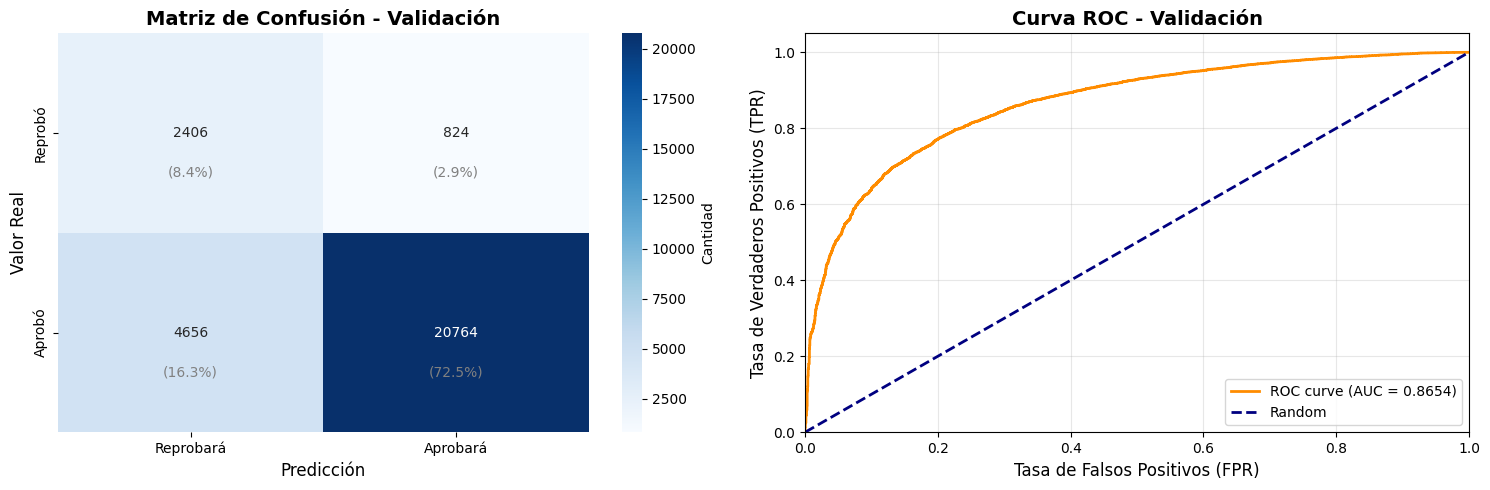


✅ EVALUACIÓN COMPLETADA



In [27]:
resultados_val = evaluar_modelo_completo(
    modelo=rf_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/rf_model_'
)

#### SVC

In [28]:
# # 2. SVM
# print(f"\n{'#'*80}")
# print(f"# MODELO 2: SVM")
# print(f"{'#'*80}")
# svm_model = SVC(
#     kernel='rbf',
#     C=1.0,
#     gamma='scale',
#     probability=True,
#     random_state=42,
#     class_weight='balanced'
# )
# svm_model = entrenar_evaluar_modelo('SVM', svm_model, X_train, y_train, X_val, y_val, X_test, y_test)
# joblib.dump(svm_model, 'models/svm_model.pkl')
# print(f"\n💾 Modelo guardado en 'models/svm_model.pkl'")

#### LogisticRegression

In [29]:
# 3. Regresión Logística
print(f"\n{'#'*80}")
print(f"# MODELO 3: REGRESIÓN LOGÍSTICA")
print(f"{'#'*80}")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)
lr_model = entrenar_evaluar_modelo('Regresión Logística', lr_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(lr_model, 'models/logistic_regression_model.pkl')
print(f"\n💾 Modelo guardado en 'models/logistic_regression_model.pkl'")


################################################################################
# MODELO 3: REGRESIÓN LOGÍSTICA
################################################################################

🤖 Entrenando Regresión Logística...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.7198
  ROC-AUC: 0.7854

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.7201
  ROC-AUC: 0.7880

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.26      0.71      0.38      7433
    Aprobado       0.95      0.72      0.82     53309

    accuracy                           0.72     60742
   macro avg       0.60      0.71      0.60     60742
weighted avg       0.86      0.72      0.77     60742


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.7320
  ROC-AUC: 0.7822

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.25      0.67      0.36      3230
    Aprobado       0.95      0.74      0.83     254


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN



📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.7320 (73.20%)
  • Precision (Precisión):    0.9468 (94.68%)
  • Recall (Sensibilidad):    0.7395 (73.95%)
  • F1-Score:                 0.8304
  • ROC-AUC:                  0.7822

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │    2173   │     1057        │  TN / FP
  │ Aprobó  │    6621   │    18799        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 2,173 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     1,057 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     6,621 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 18,799 - Correctamente predichos como APROBARÁ

📊 DISTRIBUCIÓN:
  Real:
    - Aprobados:  25,420

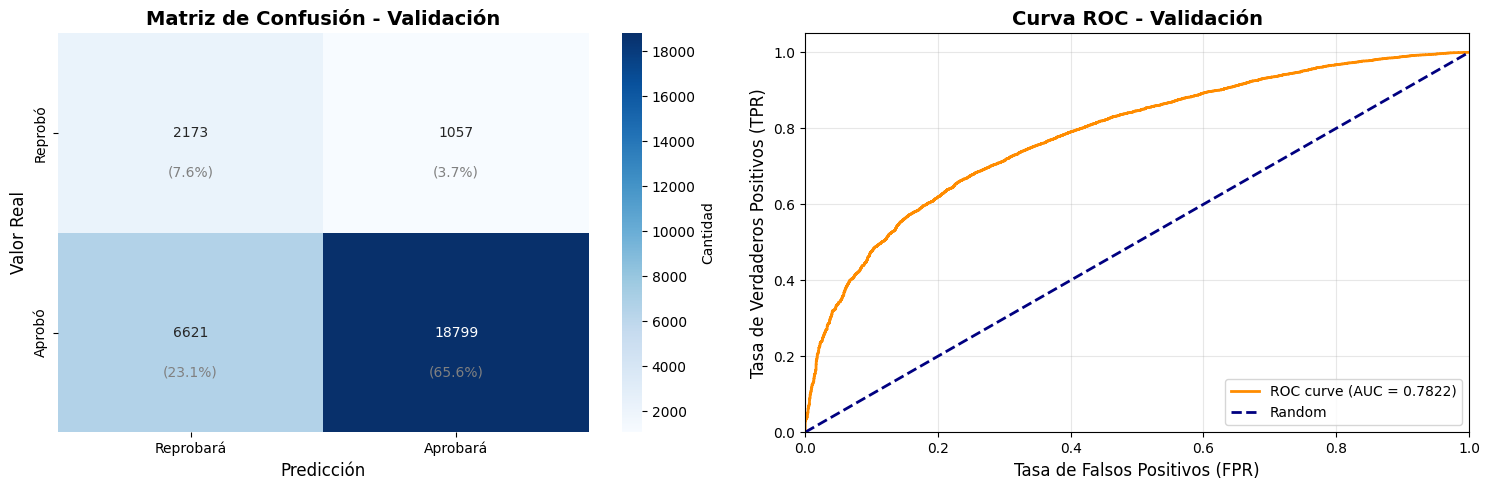


✅ EVALUACIÓN COMPLETADA



In [30]:
resultados_val = evaluar_modelo_completo(
    modelo=lr_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/lr_model_'
)

#### XGBOOST

In [31]:
# 4. XGBoost
print(f"\n{'#'*80}")
print(f"# MODELO 4: XGBOOST")
print(f"{'#'*80}")

# Calcular scale_pos_weight para balancear clases
scale_pos_weight = (y_train == 1).sum() / (y_train == 0).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
xgb_model = entrenar_evaluar_modelo('XGBoost', xgb_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(xgb_model, 'models/xgboost_model.pkl')
print(f"\n💾 Modelo guardado en 'models/xgboost_model.pkl'")


################################################################################
# MODELO 4: XGBOOST
################################################################################

🤖 Entrenando XGBoost...

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.8817
  ROC-AUC: 0.8875

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.8807
  ROC-AUC: 0.8749

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.93      0.03      0.05      7433
    Aprobado       0.88      1.00      0.94     53309

    accuracy                           0.88     60742
   macro avg       0.90      0.51      0.49     60742
weighted avg       0.89      0.88      0.83     60742


📊 MÉTRICAS EN TEST (2025-1S):
  Accuracy: 0.8884
  ROC-AUC: 0.8693

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.88      0.01      0.02      3230
    Aprobado       0.89      1.00      0.94     25420

    accuracy        


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.8884 (88.84%)
  • Precision (Precisión):    0.8884 (88.84%)
  • Recall (Sensibilidad):    0.9998 (99.98%)
  • F1-Score:                 0.9408
  • ROC-AUC:                  0.8693

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │      38   │     3192        │  TN / FP
  │ Aprobó  │       5   │    25415        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 38 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     3,192 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     5 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 25,415 - Correctamente predichos como APROBARÁ

📊 DISTRIBUCIÓN:


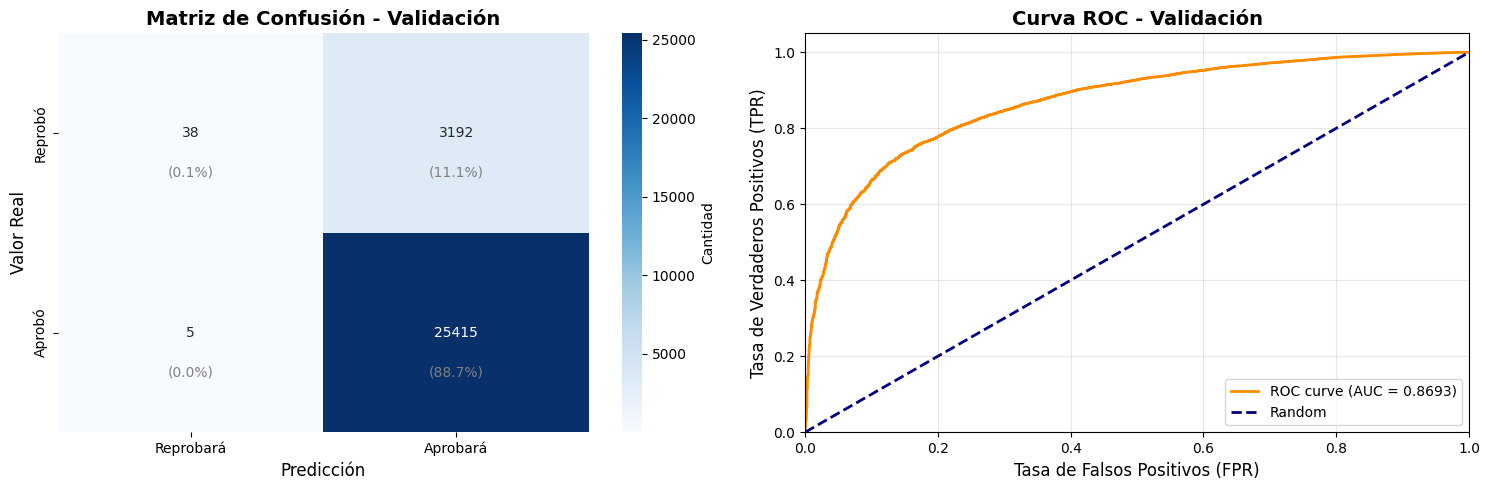


✅ EVALUACIÓN COMPLETADA



In [32]:
resultados_val = evaluar_modelo_completo(
    modelo=xgb_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/xgb_model_'
)

#### LGBMClassifier

In [33]:
# 4. LGBmodel
print(f"\n{'#'*80}")
print(f"# MODELO 4: LGBmodel")
print(f"{'#'*80}")

# Calcular scale_pos_weight para balancear clases
scale_pos_weight = (y_train == 1).sum() / (y_train == 0).sum()

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced',
    force_row_wise=True
)
lgb_model = entrenar_evaluar_modelo('LGBmodel', lgb_model, X_train, y_train, X_val, y_val, X_test, y_test)
joblib.dump(lgb_model, 'models/lgb_model.pkl')
print(f"\n💾 Modelo guardado en 'models/xgboost_model.pkl'")


################################################################################
# MODELO 4: LGBmodel
################################################################################

🤖 Entrenando LGBmodel...
[LightGBM] [Info] Number of positive: 213236, number of negative: 29731
[LightGBM] [Info] Total Bins 3168
[LightGBM] [Info] Number of data points in the train set: 242967, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

📊 MÉTRICAS EN TRAIN (80% de 2020-2024):
  Accuracy: 0.7760
  ROC-AUC: 0.8856

📊 MÉTRICAS EN VALIDACIÓN (20% de 2020-2024):
  Accuracy: 0.7701
  ROC-AUC: 0.8757

  Classification Report:
              precision    recall  f1-score   support

   Reprobado       0.33      0.83      0.47      7433
    Aprobado       0.97      0.76      0.85     53309

    accuracy                           0.77     60742
   macro avg       0.65      0.79      0.66     607


📊 EVALUACIÓN DEL MODELO EN VALIDACIÓN

📈 MÉTRICAS GENERALES:
  • Accuracy (Exactitud):     0.7729 (77.29%)
  • Precision (Precisión):    0.9703 (97.03%)
  • Recall (Sensibilidad):    0.7675 (76.75%)
  • F1-Score:                 0.8571
  • ROC-AUC:                  0.8713

📊 MATRIZ DE CONFUSIÓN:
  ┌─────────────────────────────────────┐
  │           Predicción                │
  │         Reprobará  │  Aprobará      │
  ├─────────────────────────────────────┤
  │ Real    │         │                 │
  │ Reprobó │    2633   │      597        │  TN / FP
  │ Aprobó  │    5909   │    19511        │  FN / TP
  └─────────────────────────────────────┘

📋 INTERPRETACIÓN:
  • Verdaderos Negativos (TN): 2,633 - Correctamente predichos como REPROBARÁ
  • Falsos Positivos (FP):     597 - Incorrectamente predichos como APROBARÁ
  • Falsos Negativos (FN):     5,909 - Incorrectamente predichos como REPROBARÁ
  • Verdaderos Positivos (TP): 19,511 - Correctamente predichos como APROBARÁ

📊 DISTRIBUC

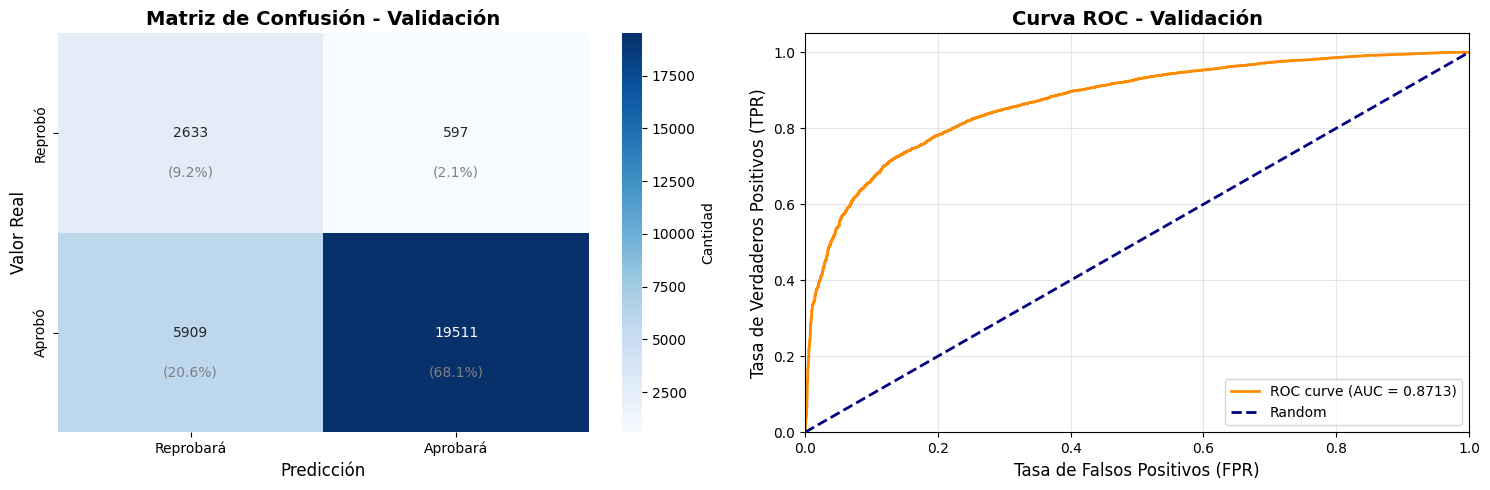


✅ EVALUACIÓN COMPLETADA



In [34]:
resultados_val = evaluar_modelo_completo(
    modelo=lgb_model,
    X=X_test,
    y=y_test,
    nombre_conjunto='Validación',
    mostrar_graficos=True,
    guardar_graficos=True,
    ruta_guardado='models/lgb_model_'
)

### APRENDIZAJE NO SUPERVISADO

In [35]:
print(f"Preparando datos para clustering...")

# Usar solo datos de entrenamiento para evitar data leakage
X_unsupervised = df_train_val[X_columns].copy()
# X_unsupervised = df_rest[X_columns].copy()

y_unsupervised = df_train_val['APROBO'].copy()
# y_unsupervised = df_rest['APROBO'].copy()

# Eliminar nulos
X_unsupervised = X_unsupervised.fillna(X_unsupervised.median())

print(f"  • Shape: {X_unsupervised.shape}")
print(f"  • Features numéricas: {len(features_numericas)}")

# Estandarizar datos (CRÍTICO para clustering y PCA/t-SNE)
print(f"\n🔄 Estandarizando datos...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

# Guardar scaler para uso futuro
joblib.dump(scaler, 'models/scaler_unsupervised.pkl')
print(f"  ✓ Scaler guardado en 'models/scaler_unsupervised.pkl'")

Preparando datos para clustering...
  • Shape: (303709, 43)
  • Features numéricas: 24

🔄 Estandarizando datos...
  ✓ Scaler guardado en 'models/scaler_unsupervised.pkl'


#### K-MEANS CLUSTERING

In [36]:
# Método del codo para encontrar k óptimo
print(f"\n📈 Método del Codo - Buscando k óptimo...")
inertias = []
silhouette_scores = []
k_range = range(2, 5)

for k in k_range:
    print("k:", k)
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    print(f"  k={k}: Inertia={kmeans_temp.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")


📈 Método del Codo - Buscando k óptimo...
k: 2
  k=2: Inertia=12398245.48, Silhouette=0.0564
k: 3
  k=3: Inertia=11909513.30, Silhouette=0.0440
k: 4
  k=4: Inertia=11340244.02, Silhouette=0.0459


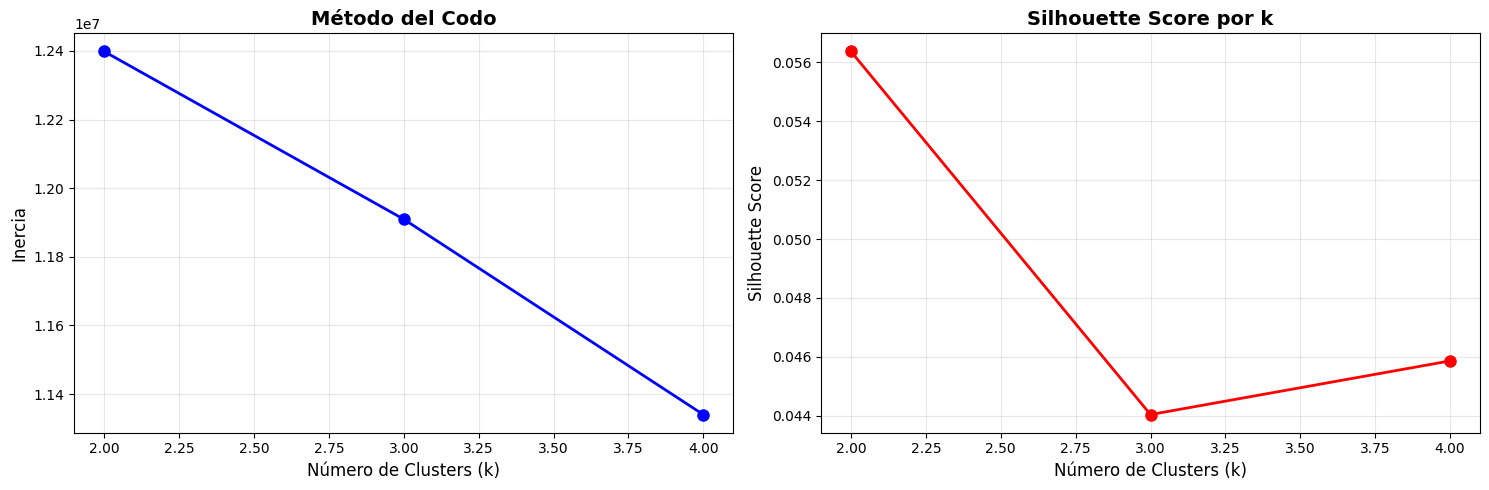

In [37]:
# Graficar método del codo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inercia', fontsize=12)
ax1.set_title('Método del Codo', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score por k', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# K-Means con k óptimo (ajustar según resultados)
k_optimo = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 porque range empieza en 2
print(f"\n🎯 K óptimo seleccionado: {k_optimo}")


🎯 K óptimo seleccionado: 2


In [39]:
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10, max_iter=300)
kmeans_labels = kmeans.fit_predict(X_scaled)

In [40]:
# Métricas de evaluación
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)

print(f"\n📊 MÉTRICAS K-MEANS:")
print(f"  • Silhouette Score: {silhouette_kmeans:.4f} (mejor si cercano a 1)")
print(f"  • Davies-Bouldin Index: {davies_bouldin_kmeans:.4f} (mejor si bajo)")
print(f"  • Calinski-Harabasz Score: {calinski_harabasz_kmeans:.2f} (mejor si alto)")


📊 MÉTRICAS K-MEANS:
  • Silhouette Score: 0.0564 (mejor si cercano a 1)
  • Davies-Bouldin Index: 4.0048 (mejor si bajo)
  • Calinski-Harabasz Score: 16197.94 (mejor si alto)


In [41]:
# Distribución de clusters
print(f"\n📊 Distribución de Clusters:")
for i in range(k_optimo):
    count = (kmeans_labels == i).sum()
    pct = count / len(kmeans_labels) * 100
    aprobados = y_unsupervised[kmeans_labels == i].mean() * 100
    print(f"  • Cluster {i}: {count:,} estudiantes ({pct:.2f}%) - {aprobados:.2f}% aprobados")


📊 Distribución de Clusters:
  • Cluster 0: 158,090 estudiantes (52.05%) - 83.91% aprobados
  • Cluster 1: 145,619 estudiantes (47.95%) - 91.95% aprobados


In [42]:
# Guardar modelo y labels
joblib.dump(kmeans, 'models/kmeans_model.pkl')
df_train_val['cluster_kmeans'] = kmeans_labels
print(f"\n💾 Modelo K-Means guardado en 'models/kmeans_model.pkl'")


💾 Modelo K-Means guardado en 'models/kmeans_model.pkl'


#### CLUSTERING JERÁRQUICO

In [43]:
print(f"\n{'#'*80}")
print(f"# 2. CLUSTERING JERÁRQUICO (AGGLOMERATIVE)")
print(f"{'#'*80}")

# Usar muestra si el dataset es muy grande (>10k registros)
sample_size = min(5000, len(X_scaled))
if len(X_scaled) > sample_size:
    print(f"\n⚠️ Dataset grande, usando muestra de {sample_size:,} registros para dendrograma")
    indices_sample = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[indices_sample]
else:
    X_sample = X_scaled
    indices_sample = np.arange(len(X_scaled))


################################################################################
# 2. CLUSTERING JERÁRQUICO (AGGLOMERATIVE)
################################################################################

⚠️ Dataset grande, usando muestra de 5,000 registros para dendrograma



🌳 Generando dendrograma...


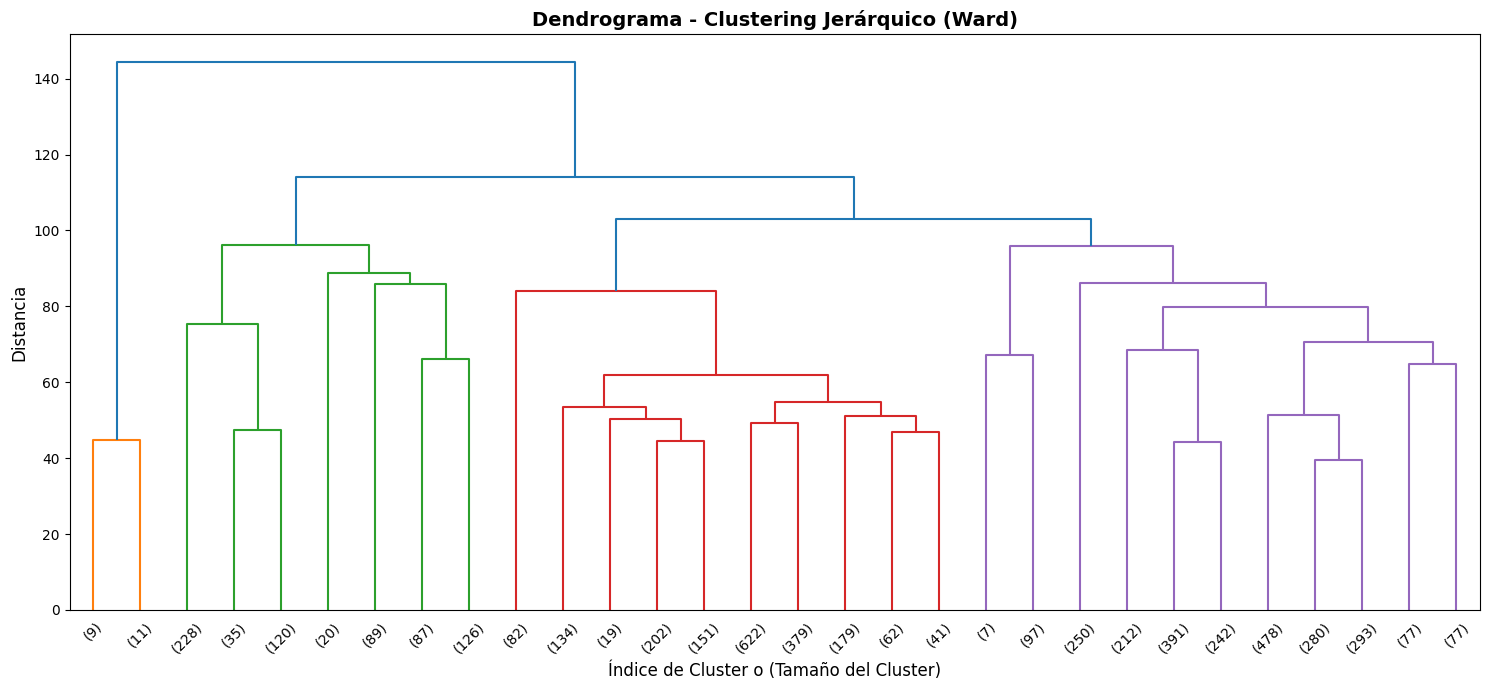

In [44]:
print(f"\n🌳 Generando dendrograma...")
linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title('Dendrograma - Clustering Jerárquico (Ward)', fontsize=14, fontweight='bold')
plt.xlabel('Índice de Cluster o (Tamaño del Cluster)', fontsize=12)
plt.ylabel('Distancia', fontsize=12)
plt.tight_layout()
plt.savefig('models/hierarchical_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()


################################################################################
# 2. CLUSTERING JERÁRQUICO (AGGLOMERATIVE) - VERSIÓN OPTIMIZADA
################################################################################
📊 Memoria disponible: 3.2 GB
📊 Tamaño de muestra para clustering jerárquico: 7,056
⚠️ Usando muestra estratificada de 7,056 registros

🌳 Generando dendrograma...


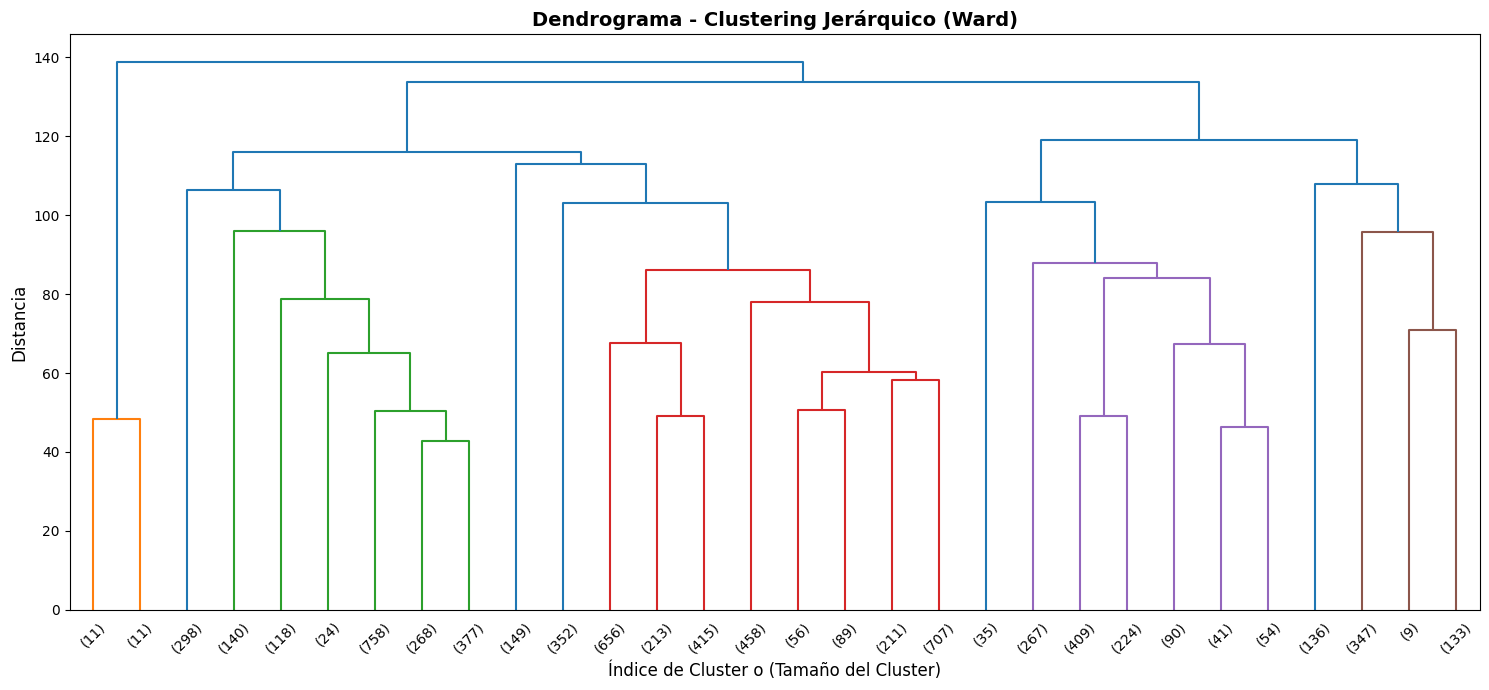


🔄 Extendiendo clusters a todos los datos...
✅ Clusters asignados usando KNN


In [45]:
# Clustering jerárquico con k óptimo
n_clusters_hier = k_optimo  # Usar mismo k que K-Means para comparar

print(f"\n{'#'*80}")
print(f"# 2. CLUSTERING JERÁRQUICO (AGGLOMERATIVE) - VERSIÓN OPTIMIZADA")
print(f"{'#'*80}")

# Determinar tamaño de muestra basado en memoria disponible
import psutil
memoria_disponible_gb = psutil.virtual_memory().available / (1024**3)
max_registros = min(int(np.sqrt(memoria_disponible_gb * 1e9 / 64)), len(X_scaled))  # Estimación conservadora
sample_size_hier = min(max_registros, 10000)  # Máximo 10k para ser seguros

print(f"📊 Memoria disponible: {memoria_disponible_gb:.1f} GB")
print(f"📊 Tamaño de muestra para clustering jerárquico: {sample_size_hier:,}")

if sample_size_hier < len(X_scaled):
    print(f"⚠️ Usando muestra estratificada de {sample_size_hier:,} registros")
    
    # Muestra estratificada para mantener distribución
    from sklearn.model_selection import train_test_split
    indices_sample, _ = train_test_split(
        range(len(X_scaled)), 
        train_size=sample_size_hier,
        stratify=y_unsupervised,
        random_state=42
    )
    
    X_sample_hier = X_scaled[indices_sample]
    y_sample_hier = y_unsupervised.iloc[indices_sample]
else:
    X_sample_hier = X_scaled
    y_sample_hier = y_unsupervised
    indices_sample = np.arange(len(X_scaled))

# Dendrograma con muestra
print(f"\n🌳 Generando dendrograma...")
linkage_matrix = linkage(X_sample_hier, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title('Dendrograma - Clustering Jerárquico (Ward)', fontsize=14, fontweight='bold')
plt.xlabel('Índice de Cluster o (Tamaño del Cluster)', fontsize=12)
plt.ylabel('Distancia', fontsize=12)
plt.tight_layout()
plt.savefig('models/hierarchical_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Clustering jerárquico en muestra
hierarchical = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
hierarchical_labels_sample = hierarchical.fit_predict(X_sample_hier)

# Extender a todos los datos usando KNN
if sample_size_hier < len(X_scaled):
    print(f"\n🔄 Extendiendo clusters a todos los datos...")
    knn_cluster = KNeighborsClassifier(n_neighbors=5)
    knn_cluster.fit(X_sample_hier, hierarchical_labels_sample)
    hierarchical_labels = knn_cluster.predict(X_scaled)
    print(f"✅ Clusters asignados usando KNN")
else:
    hierarchical_labels = hierarchical_labels_sample

# Métricas
silhouette_hier = silhouette_score(X_scaled, hierarchical_labels)
davies_bouldin_hier = davies_bouldin_score(X_scaled, hierarchical_labels)
calinski_harabasz_hier = calinski_harabasz_score(X_scaled, hierarchical_labels)



# hierarchical = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
# hierarchical_labels = hierarchical.fit_predict(X_scaled)

# # Métricas
# silhouette_hier = silhouette_score(X_scaled, hierarchical_labels_sample)
# davies_bouldin_hier = davies_bouldin_score(X_scaled, hierarchical_labels_sample)
# calinski_harabasz_hier = calinski_harabasz_score(X_scaled, hierarchical_labels_sample)

In [46]:
print(f"\n📊 MÉTRICAS CLUSTERING JERÁRQUICO:")
print(f"  • Silhouette Score: {silhouette_hier:.4f}")
print(f"  • Davies-Bouldin Index: {davies_bouldin_hier:.4f}")
print(f"  • Calinski-Harabasz Score: {calinski_harabasz_hier:.2f}")

# Distribución
print(f"\n📊 Distribución de Clusters:")
for i in range(n_clusters_hier):
    count = (hierarchical_labels == i).sum()
    pct = count / len(hierarchical_labels) * 100
    aprobados = y_unsupervised[hierarchical_labels == i].mean() * 100
    print(f"  • Cluster {i}: {count:,} estudiantes ({pct:.2f}%) - {aprobados:.2f}% aprobados")


📊 MÉTRICAS CLUSTERING JERÁRQUICO:
  • Silhouette Score: 0.6455
  • Davies-Bouldin Index: 0.7916
  • Calinski-Harabasz Score: 13995.26

📊 Distribución de Clusters:
  • Cluster 0: 302,410 estudiantes (99.57%) - 87.76% aprobados
  • Cluster 1: 1,299 estudiantes (0.43%) - 88.68% aprobados


In [47]:
# Guardar
joblib.dump(hierarchical, 'models/hierarchical_model.pkl')
df_train_val['cluster_hierarchical'] = hierarchical_labels
print(f"\n💾 Modelo Jerárquico guardado en 'models/hierarchical_model.pkl'")


💾 Modelo Jerárquico guardado en 'models/hierarchical_model.pkl'


#### DBSCAN

In [48]:
print(f"\n📈 Buscando eps óptimo con k-distance graph...")
k = 5  # MinPts recomendado
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)


📈 Buscando eps óptimo con k-distance graph...


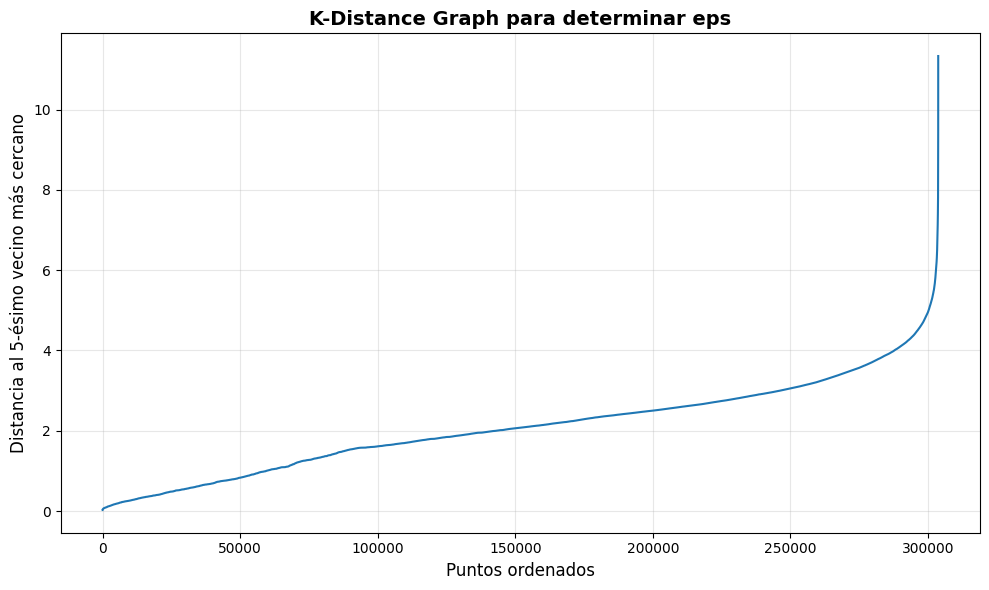

In [49]:
# Ordenar distancias
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Puntos ordenados', fontsize=12)
plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano', fontsize=12)
plt.title('K-Distance Graph para determinar eps', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('models/dbscan_kdistance.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Sugerir eps (punto de inflexión aproximado)
eps_sugerido = np.percentile(distances, 95)
print(f"  • Eps sugerido (percentil 95): {eps_sugerido:.4f}")

  • Eps sugerido (percentil 95): 4.0339


In [54]:
# DBSCAN - Versión ultra conservadora
eps = eps_sugerido
min_samples = 15

print(f"\n🔄 Ejecutando DBSCAN (versión conservadora)...")

# Usar muestra pequeña para DBSCAN
sample_size_dbscan = min(5000, len(X_scaled))
print(f"  • Usando muestra de {sample_size_dbscan:,} registros")

indices_dbscan = np.random.choice(len(X_scaled), sample_size_dbscan, replace=False)
X_dbscan_sample = X_scaled[indices_dbscan]

# DBSCAN simple
dbscan = DBSCAN(
    eps=eps * 0.8,  # Reducir eps ligeramente
    min_samples=min_samples,
    metric='euclidean',
    n_jobs=1
)

dbscan_labels_sample = dbscan.fit_predict(X_dbscan_sample)

# Crear labels para todo el dataset basado en muestra
dbscan_labels = np.full(len(X_scaled), -1)  # Inicializar todo como ruido

# Si hay clusters válidos, usar KNN para extender
clusters_validos = set(dbscan_labels_sample) - {-1}
if len(clusters_validos) > 0:
    from sklearn.neighbors import KNeighborsClassifier
    
    mask_no_noise = dbscan_labels_sample != -1
    if mask_no_noise.sum() > 10:  # Al menos 10 puntos válidos
        knn_dbscan = KNeighborsClassifier(n_neighbors=3)
        knn_dbscan.fit(X_dbscan_sample[mask_no_noise], dbscan_labels_sample[mask_no_noise])
        
        # Predecir solo para una fracción de los datos (por memoria)
        batch_size = 1000
        for i in range(0, len(X_scaled), batch_size):
            end_idx = min(i + batch_size, len(X_scaled))
            batch_predictions = knn_dbscan.predict(X_scaled[i:end_idx])
            dbscan_labels[i:end_idx] = batch_predictions
        
        print(f"  ✅ Clusters extendidos usando KNN en lotes")

# Número de clusters
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"  ✅ DBSCAN completado")


🔄 Ejecutando DBSCAN (versión conservadora)...
  • Usando muestra de 5,000 registros
  ✅ Clusters extendidos usando KNN en lotes
  ✅ DBSCAN completado


In [55]:
print(f"\n📊 RESULTADOS DBSCAN:")
print(f"  • Eps: {eps:.4f}")
print(f"  • Min samples: {min_samples}")
print(f"  • Clusters encontrados: {n_clusters_dbscan}")
print(f"  • Puntos de ruido: {n_noise:,} ({n_noise/len(dbscan_labels)*100:.2f}%)")


📊 RESULTADOS DBSCAN:
  • Eps: 4.0339
  • Min samples: 15
  • Clusters encontrados: 3
  • Puntos de ruido: 0 (0.00%)


In [56]:
# Métricas (solo si hay más de 1 cluster y menos ruido que datos)
if n_clusters_dbscan > 1 and n_noise < len(dbscan_labels) * 0.5:
    # Filtrar ruido para métricas
    mask_no_noise = dbscan_labels != -1
    if mask_no_noise.sum() > 0:
        silhouette_dbscan = silhouette_score(X_scaled[mask_no_noise], dbscan_labels[mask_no_noise])
        davies_bouldin_dbscan = davies_bouldin_score(X_scaled[mask_no_noise], dbscan_labels[mask_no_noise])
        calinski_harabasz_dbscan = calinski_harabasz_score(X_scaled[mask_no_noise], dbscan_labels[mask_no_noise])
        
        print(f"\n📊 MÉTRICAS DBSCAN (sin ruido):")
        print(f"  • Silhouette Score: {silhouette_dbscan:.4f}")
        print(f"  • Davies-Bouldin Index: {davies_bouldin_dbscan:.4f}")
        print(f"  • Calinski-Harabasz Score: {calinski_harabasz_dbscan:.2f}")
else:
    print(f"\n⚠️ DBSCAN no encontró clusters significativos. Ajustar eps o min_samples.")


📊 MÉTRICAS DBSCAN (sin ruido):
  • Silhouette Score: 0.0258
  • Davies-Bouldin Index: 5.3648
  • Calinski-Harabasz Score: 5921.71


In [57]:
# Distribución
print(f"\n📊 Distribución de Clusters:")
for i in sorted(set(dbscan_labels)):
    count = (dbscan_labels == i).sum()
    pct = count / len(dbscan_labels) * 100
    if i == -1:
        print(f"  • Ruido: {count:,} estudiantes ({pct:.2f}%)")
    else:
        aprobados = y_unsupervised[dbscan_labels == i].mean() * 100
        print(f"  • Cluster {i}: {count:,} estudiantes ({pct:.2f}%) - {aprobados:.2f}% aprobados")


📊 Distribución de Clusters:
  • Cluster 0: 86,152 estudiantes (28.37%) - 88.40% aprobados
  • Cluster 1: 187,620 estudiantes (61.78%) - 89.25% aprobados
  • Cluster 2: 29,937 estudiantes (9.86%) - 76.60% aprobados


In [58]:
# Guardar
joblib.dump(dbscan, 'models/dbscan_model.pkl')
df_train_val['cluster_dbscan'] = dbscan_labels
print(f"\n💾 Modelo DBSCAN guardado en 'models/dbscan_model.pkl'")


💾 Modelo DBSCAN guardado en 'models/dbscan_model.pkl'


#### MEAN SHIFT

In [59]:
# Mean Shift puede ser lento con muchos datos
sample_size_ms = min(3000, len(X_scaled))
if len(X_scaled) > sample_size_ms:
    print(f"\n⚠️ Mean Shift es computacionalmente costoso.")
    print(f"    Usando muestra de {sample_size_ms:,} registros para entrenamiento...")
    indices_ms = np.random.choice(len(X_scaled), sample_size_ms, replace=False)
    X_ms = X_scaled[indices_ms]
else:
    X_ms = X_scaled
    indices_ms = np.arange(len(X_scaled))


⚠️ Mean Shift es computacionalmente costoso.
    Usando muestra de 3,000 registros para entrenamiento...


In [60]:
print(f"\n🔍 Estimando bandwidth óptimo...")
bandwidth = estimate_bandwidth(X_ms, quantile=0.2, n_samples=500)
print(f"  • Bandwidth estimado: {bandwidth:.4f}")

# %%
# Mean Shift
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
meanshift.fit(X_ms)

# Predecir para todos los datos
meanshift_labels = meanshift.predict(X_scaled)

n_clusters_ms = len(meanshift.cluster_centers_)


🔍 Estimando bandwidth óptimo...
  • Bandwidth estimado: 7.4441


In [61]:
print(f"\n📊 RESULTADOS MEAN SHIFT:")
print(f"  • Bandwidth: {bandwidth:.4f}")
print(f"  • Clusters encontrados: {n_clusters_ms}")

# Métricas
if n_clusters_ms > 1:
    silhouette_ms = silhouette_score(X_scaled, meanshift_labels)
    davies_bouldin_ms = davies_bouldin_score(X_scaled, meanshift_labels)
    calinski_harabasz_ms = calinski_harabasz_score(X_scaled, meanshift_labels)
    
    print(f"\n📊 MÉTRICAS MEAN SHIFT:")
    print(f"  • Silhouette Score: {silhouette_ms:.4f}")
    print(f"  • Davies-Bouldin Index: {davies_bouldin_ms:.4f}")
    print(f"  • Calinski-Harabasz Score: {calinski_harabasz_ms:.2f}")
else:
    print(f"\n⚠️ Mean Shift encontró solo 1 cluster. Ajustar bandwidth.")

# Distribución
print(f"\n📊 Distribución de Clusters:")
for i in range(n_clusters_ms):
    count = (meanshift_labels == i).sum()
    pct = count / len(meanshift_labels) * 100
    aprobados = y_unsupervised[meanshift_labels == i].mean() * 100
    print(f"  • Cluster {i}: {count:,} estudiantes ({pct:.2f}%) - {aprobados:.2f}% aprobados")


📊 RESULTADOS MEAN SHIFT:
  • Bandwidth: 7.4441
  • Clusters encontrados: 18

📊 MÉTRICAS MEAN SHIFT:
  • Silhouette Score: 0.2442
  • Davies-Bouldin Index: 1.7090
  • Calinski-Harabasz Score: 2638.09

📊 Distribución de Clusters:
  • Cluster 0: 295,313 estudiantes (97.24%) - 88.08% aprobados
  • Cluster 1: 1,373 estudiantes (0.45%) - 56.96% aprobados
  • Cluster 2: 805 estudiantes (0.27%) - 79.88% aprobados
  • Cluster 3: 225 estudiantes (0.07%) - 93.33% aprobados
  • Cluster 4: 347 estudiantes (0.11%) - 87.90% aprobados
  • Cluster 5: 1,324 estudiantes (0.44%) - 80.89% aprobados
  • Cluster 6: 925 estudiantes (0.30%) - 68.76% aprobados
  • Cluster 7: 948 estudiantes (0.31%) - 62.66% aprobados
  • Cluster 8: 364 estudiantes (0.12%) - 100.00% aprobados
  • Cluster 9: 643 estudiantes (0.21%) - 98.91% aprobados
  • Cluster 10: 24 estudiantes (0.01%) - 95.83% aprobados
  • Cluster 11: 123 estudiantes (0.04%) - 92.68% aprobados
  • Cluster 12: 231 estudiantes (0.08%) - 92.21% aprobados
  • C

In [62]:
joblib.dump(meanshift, 'models/meanshift_model.pkl')
df_train_val['cluster_meanshift'] = meanshift_labels
print(f"\n💾 Modelo Mean Shift guardado en 'models/meanshift_model.pkl'")


💾 Modelo Mean Shift guardado en 'models/meanshift_model.pkl'


#### PCA

In [63]:
# PCA para ver varianza explicada
print(f"\n📊 Analizando componentes principales...")
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza explicada acumulada
varianza_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

# Encontrar número de componentes para 95% de varianza
n_components_95 = np.argmax(varianza_acumulada >= 0.95) + 1
n_components_90 = np.argmax(varianza_acumulada >= 0.90) + 1


📊 Analizando componentes principales...


In [64]:
print(f"\n📈 VARIANZA EXPLICADA:")
print(f"  • Componentes para 90% varianza: {n_components_90}")
print(f"  • Componentes para 95% varianza: {n_components_95}")
print(f"  • Total de features originales: {X_scaled.shape[1]}")


📈 VARIANZA EXPLICADA:
  • Componentes para 90% varianza: 31
  • Componentes para 95% varianza: 34
  • Total de features originales: 43


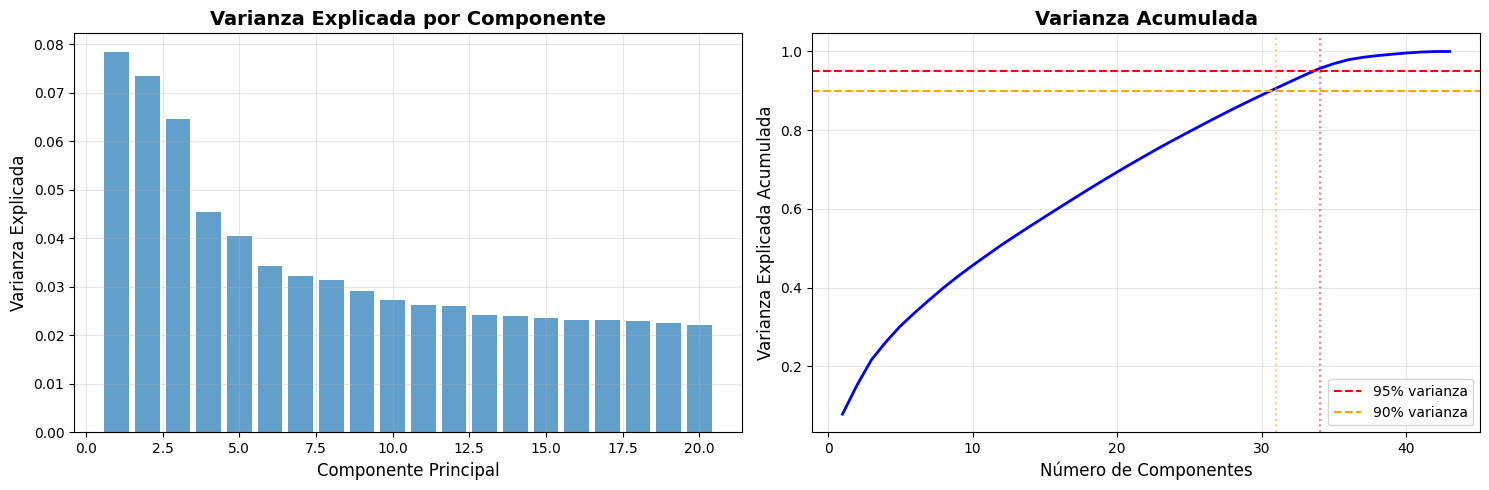

In [65]:
# Graficar varianza explicada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Varianza por componente
ax1.bar(range(1, min(21, len(pca_full.explained_variance_ratio_)+1)), 
        pca_full.explained_variance_ratio_[:20], alpha=0.7)
ax1.set_xlabel('Componente Principal', fontsize=12)
ax1.set_ylabel('Varianza Explicada', fontsize=12)
ax1.set_title('Varianza Explicada por Componente', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Varianza acumulada
ax2.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, 'b-', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% varianza')
ax2.axvline(x=n_components_95, color='r', linestyle=':', alpha=0.5)
ax2.axvline(x=n_components_90, color='orange', linestyle=':', alpha=0.5)
ax2.set_xlabel('Número de Componentes', fontsize=12)
ax2.set_ylabel('Varianza Explicada Acumulada', fontsize=12)
ax2.set_title('Varianza Acumulada', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
# PCA con n componentes óptimo
n_components_pca = n_components_95  # Usar 95% de varianza

pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled)

print(f"\n✅ PCA aplicado con {n_components_pca} componentes")
print(f"  • Varianza explicada total: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  • Shape original: {X_scaled.shape}")
print(f"  • Shape reducido: {X_pca.shape}")
print(f"  • Reducción: {(1 - X_pca.shape[1]/X_scaled.shape[1])*100:.2f}%")


✅ PCA aplicado con 34 componentes
  • Varianza explicada total: 95.67%
  • Shape original: (303709, 43)
  • Shape reducido: (303709, 34)
  • Reducción: 20.93%


In [67]:
joblib.dump(pca, 'models/pca_model.pkl')
print(f"\n💾 Modelo PCA guardado en 'models/pca_model.pkl'")

# Agregar componentes principales al dataframe
for i in range(min(5, n_components_pca)):  # Guardar solo primeros 5 componentes
    df_train_val[f'PC{i+1}'] = X_pca[:, i]


💾 Modelo PCA guardado en 'models/pca_model.pkl'



📊 Visualizando primeros 2 componentes principales...


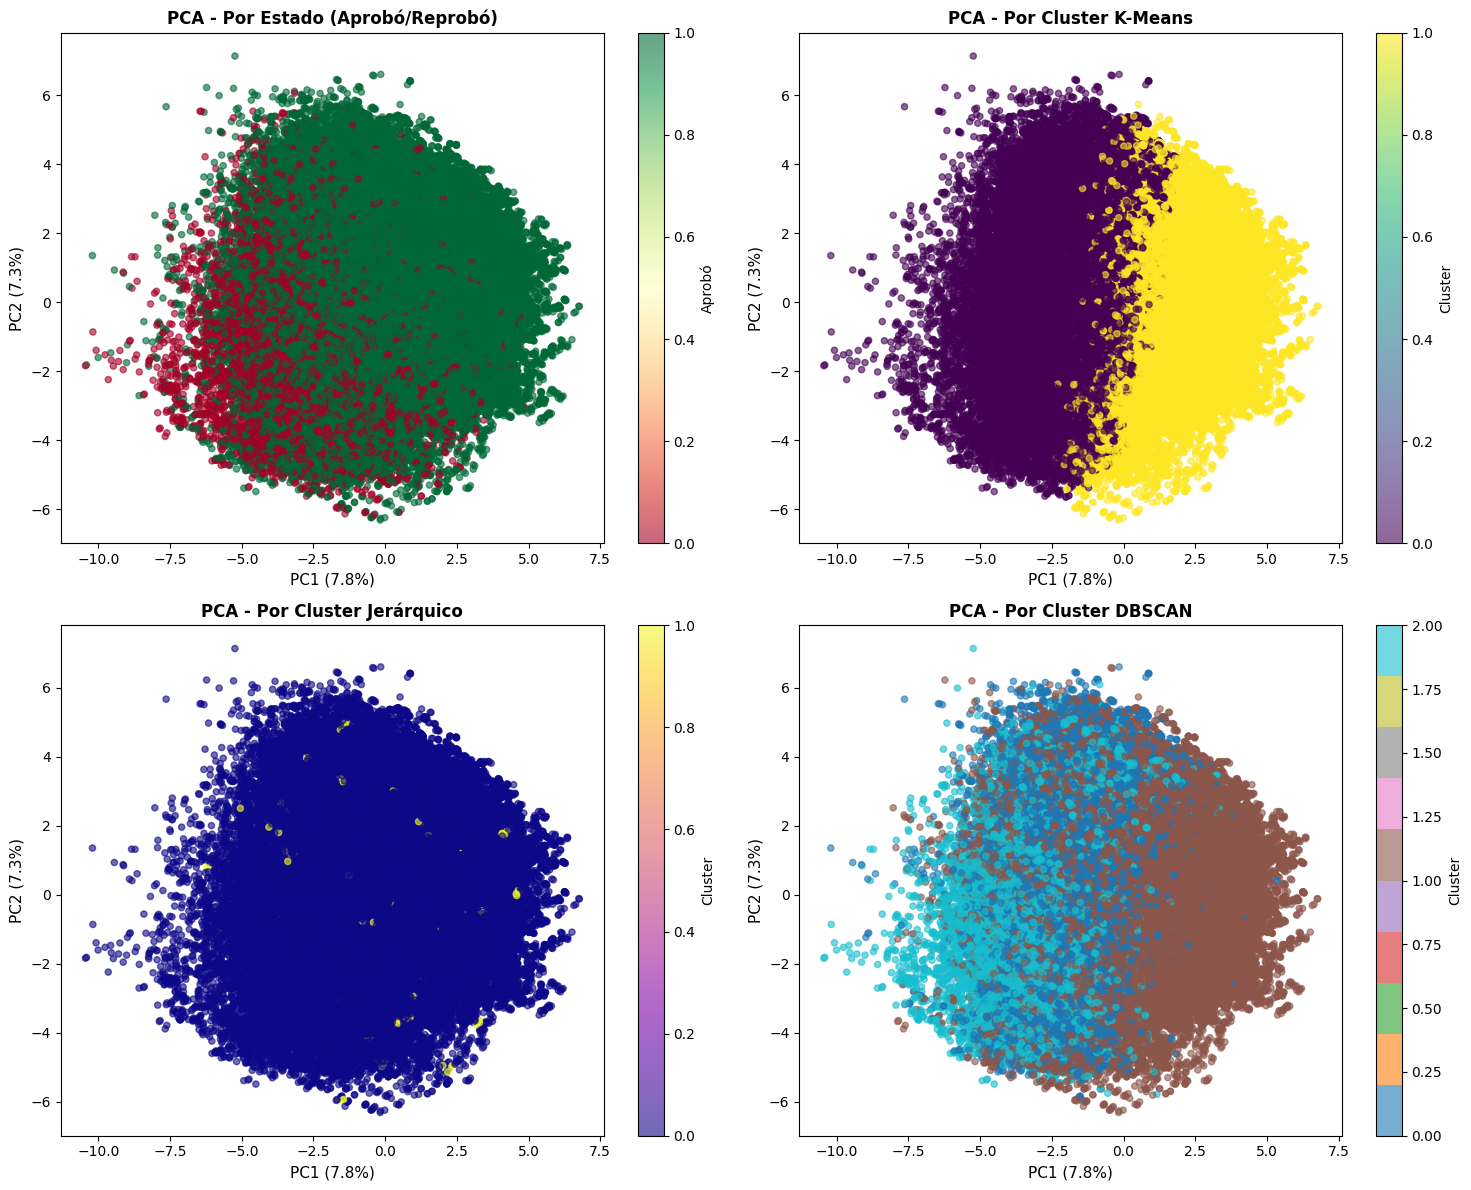

In [68]:
# Visualización 2D con primeros 2 componentes
print(f"\n📊 Visualizando primeros 2 componentes principales...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Por variable objetivo (APROBO)
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=y_unsupervised, cmap='RdYlGn', 
                              alpha=0.6, s=20)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[0, 0].set_title('PCA - Por Estado (Aprobó/Reprobó)', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0, 0], label='Aprobó')

# 2. Por K-Means
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=kmeans_labels, cmap='viridis', 
                              alpha=0.6, s=20)
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[0, 1].set_title('PCA - Por Cluster K-Means', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# 3. Por Clustering Jerárquico
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=hierarchical_labels, cmap='plasma', 
                              alpha=0.6, s=20)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[1, 0].set_title('PCA - Por Cluster Jerárquico', fontsize=12, fontweight='bold')
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# 4. Por DBSCAN
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=dbscan_labels, cmap='tab10', 
                              alpha=0.6, s=20)
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[1, 1].set_title('PCA - Por Cluster DBSCAN', fontsize=12, fontweight='bold')
plt.colorbar(scatter4, ax=axes[1, 1], label='Cluster')

plt.tight_layout()
plt.savefig('models/pca_visualization_2d.png', dpi=300, bbox_inches='tight')
plt.show()

#### t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [69]:
# t-SNE es muy costoso, usar muestra si dataset es grande
sample_size_tsne = min(5000, len(X_scaled))
if len(X_scaled) > sample_size_tsne:
    print(f"\n⚠️ t-SNE es computacionalmente costoso.")
    print(f"    Usando muestra de {sample_size_tsne:,} registros...")
    indices_tsne = np.random.choice(len(X_scaled), sample_size_tsne, replace=False)
    X_tsne_input = X_scaled[indices_tsne]
    y_tsne = y_unsupervised.iloc[indices_tsne]
    kmeans_tsne = kmeans_labels[indices_tsne]
    hierarchical_tsne = hierarchical_labels[indices_tsne]
    dbscan_tsne = dbscan_labels[indices_tsne]
else:
    X_tsne_input = X_scaled
    y_tsne = y_unsupervised
    kmeans_tsne = kmeans_labels
    hierarchical_tsne = hierarchical_labels
    dbscan_tsne = dbscan_labels
    indices_tsne = np.arange(len(X_scaled))

# %%
# Aplicar t-SNE con diferentes perplexities
print(f"\n🔄 Aplicando t-SNE (esto puede tomar varios minutos)...")

perplexities = [30, 50]  # Probar diferentes perplexities
tsne_results = {}

for perplexity in perplexities:
    print(f"\n  • Perplexity={perplexity}...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, 
                n_iter=1000, verbose=0, n_jobs=-1)
    X_tsne = tsne.fit_transform(X_tsne_input)
    tsne_results[perplexity] = X_tsne
    print(f"    ✓ Completado")


⚠️ t-SNE es computacionalmente costoso.
    Usando muestra de 5,000 registros...

🔄 Aplicando t-SNE (esto puede tomar varios minutos)...

  • Perplexity=30...
    ✓ Completado

  • Perplexity=50...
    ✓ Completado


In [70]:
# Guardar t-SNE con perplexity=30 (más común)
tsne_final = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne_final = tsne_final.fit_transform(X_tsne_input)
joblib.dump(tsne_final, 'models/tsne_model.pkl')
print(f"\n💾 Modelo t-SNE guardado en 'models/tsne_model.pkl'")


💾 Modelo t-SNE guardado en 'models/tsne_model.pkl'



📊 Visualizando t-SNE...


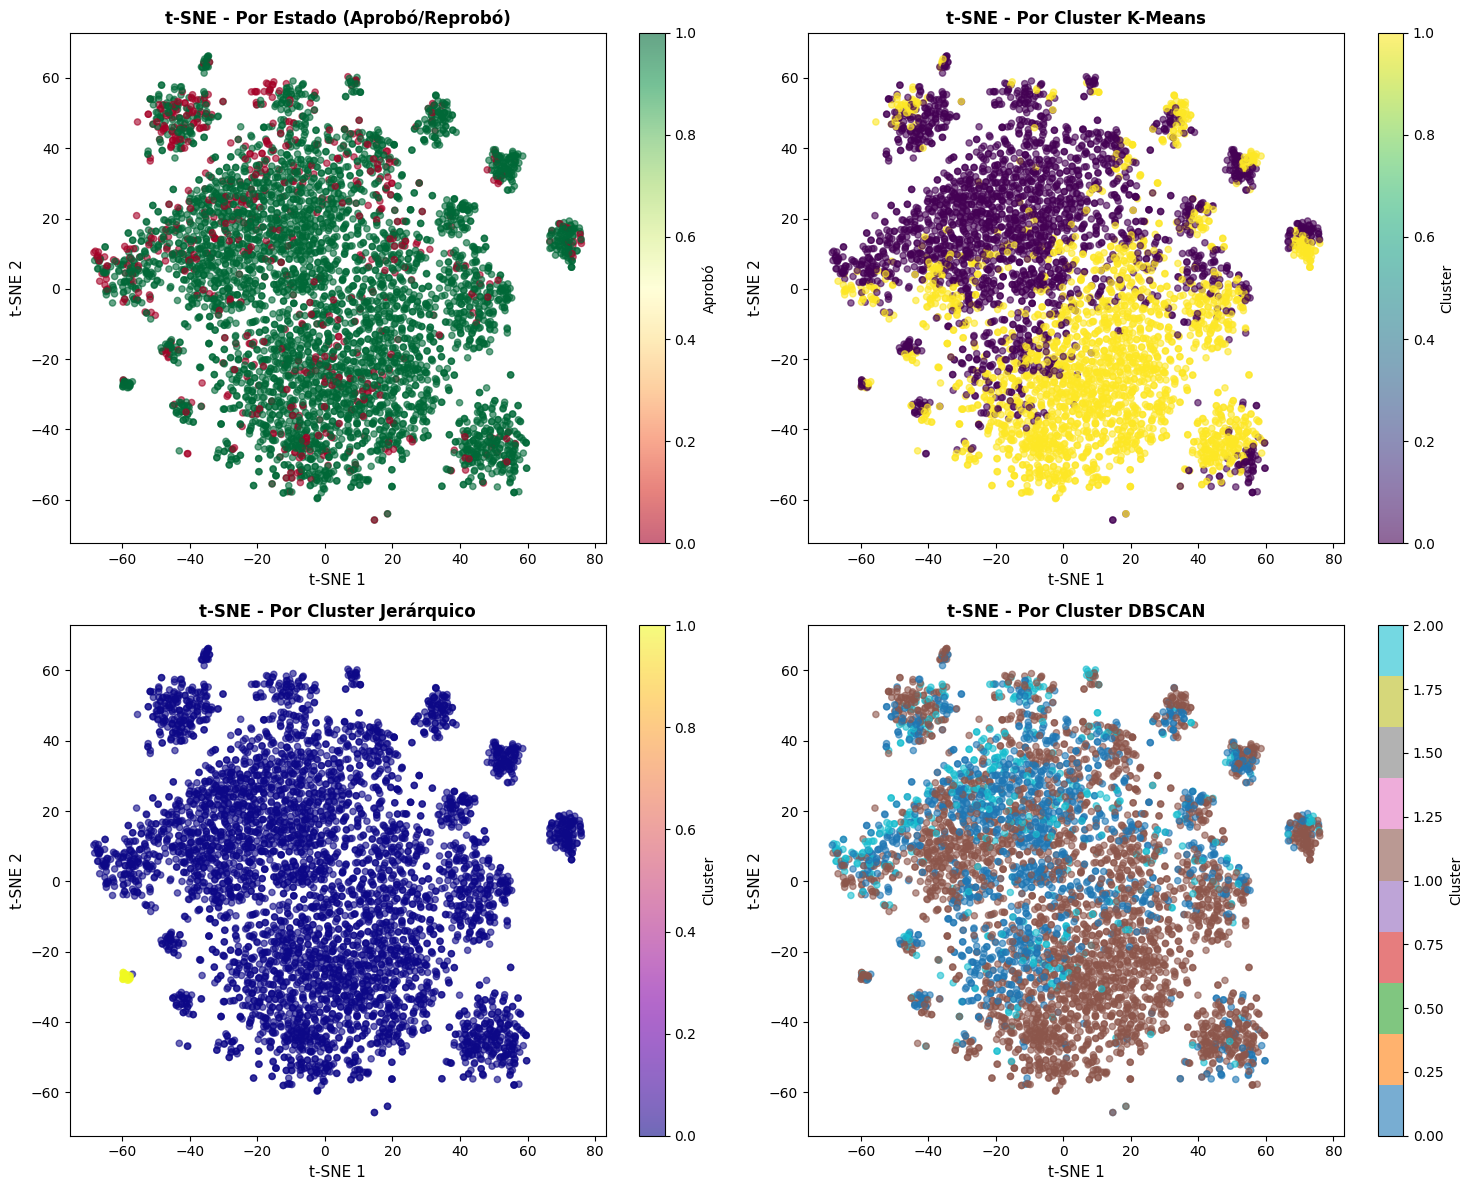

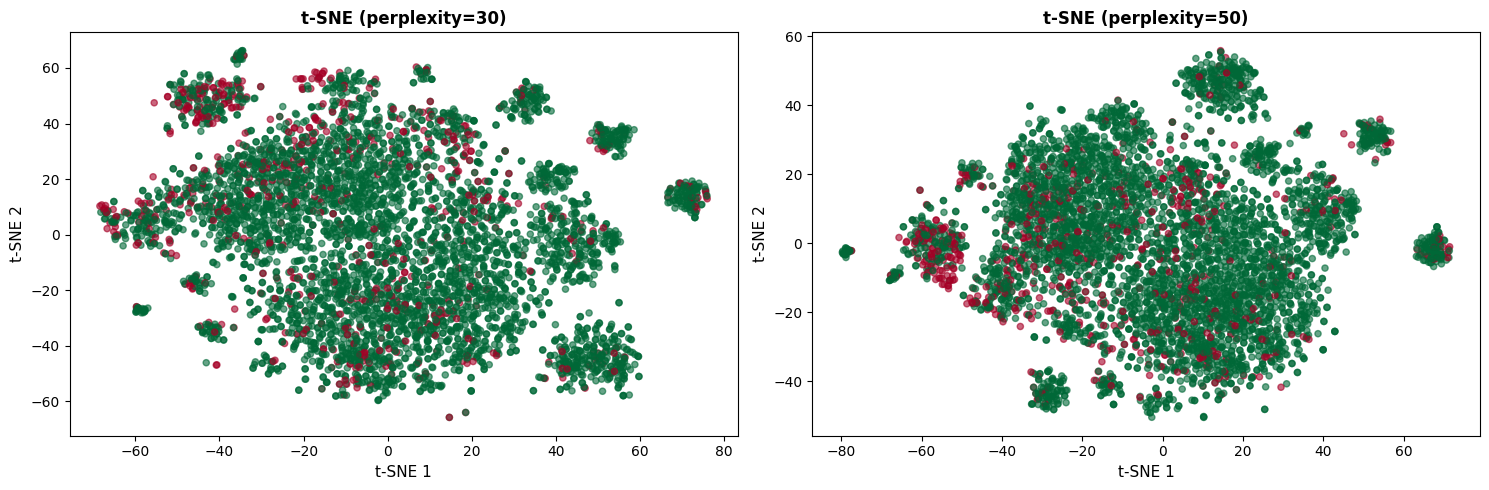

In [71]:
# Visualización t-SNE
print(f"\n📊 Visualizando t-SNE...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

X_tsne = tsne_results[30]  # Usar perplexity=30

# 1. Por variable objetivo
scatter1 = axes[0, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                              c=y_tsne, cmap='RdYlGn', 
                              alpha=0.6, s=20)
axes[0, 0].set_xlabel('t-SNE 1', fontsize=11)
axes[0, 0].set_ylabel('t-SNE 2', fontsize=11)
axes[0, 0].set_title('t-SNE - Por Estado (Aprobó/Reprobó)', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0, 0], label='Aprobó')

# 2. Por K-Means
scatter2 = axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                              c=kmeans_tsne, cmap='viridis', 
                              alpha=0.6, s=20)
axes[0, 1].set_xlabel('t-SNE 1', fontsize=11)
axes[0, 1].set_ylabel('t-SNE 2', fontsize=11)
axes[0, 1].set_title('t-SNE - Por Cluster K-Means', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# 3. Por Clustering Jerárquico
scatter3 = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                              c=hierarchical_tsne, cmap='plasma', 
                              alpha=0.6, s=20)
axes[1, 0].set_xlabel('t-SNE 1', fontsize=11)
axes[1, 0].set_ylabel('t-SNE 2', fontsize=11)
axes[1, 0].set_title('t-SNE - Por Cluster Jerárquico', fontsize=12, fontweight='bold')
plt.colorbar(scatter3, ax=axes[1, 0], label='Cluster')

# 4. Por DBSCAN
scatter4 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                              c=dbscan_tsne, cmap='tab10', 
                              alpha=0.6, s=20)
axes[1, 1].set_xlabel('t-SNE 1', fontsize=11)
axes[1, 1].set_ylabel('t-SNE 2', fontsize=11)
axes[1, 1].set_title('t-SNE - Por Cluster DBSCAN', fontsize=12, fontweight='bold')
plt.colorbar(scatter4, ax=axes[1, 1], label='Cluster')

plt.tight_layout()
plt.savefig('models/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Comparación de perplexities
if len(perplexities) > 1:
    fig, axes = plt.subplots(1, len(perplexities), figsize=(15, 5))
    
    for idx, perplexity in enumerate(perplexities):
        X_tsne_temp = tsne_results[perplexity]
        axes[idx].scatter(X_tsne_temp[:, 0], X_tsne_temp[:, 1], 
                         c=y_tsne, cmap='RdYlGn', alpha=0.6, s=20)
        axes[idx].set_xlabel('t-SNE 1', fontsize=11)
        axes[idx].set_ylabel('t-SNE 2', fontsize=11)
        axes[idx].set_title(f't-SNE (perplexity={perplexity})', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('models/tsne_perplexity_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

#### COMPARACIÓN DE MÉTODOS DE CLUSTERING

In [72]:
# Tabla comparativa
comparacion = pd.DataFrame({
    'Método': ['K-Means', 'Jerárquico', 'DBSCAN', 'Mean Shift'],
    'N° Clusters': [k_optimo, n_clusters_hier, n_clusters_dbscan, n_clusters_ms],
    'Silhouette': [silhouette_kmeans, silhouette_hier, 
                   silhouette_dbscan if n_clusters_dbscan > 1 else np.nan,
                   silhouette_ms if n_clusters_ms > 1 else np.nan],
    'Davies-Bouldin': [davies_bouldin_kmeans, davies_bouldin_hier,
                       davies_bouldin_dbscan if n_clusters_dbscan > 1 else np.nan,
                       davies_bouldin_ms if n_clusters_ms > 1 else np.nan],
    'Calinski-Harabasz': [calinski_harabasz_kmeans, calinski_harabasz_hier,
                          calinski_harabasz_dbscan if n_clusters_dbscan > 1 else np.nan,
                          calinski_harabasz_ms if n_clusters_ms > 1 else np.nan]
})

print(f"\n{comparacion.to_string(index=False)}")

# Mejor método según Silhouette Score
mejor_metodo = comparacion.loc[comparacion['Silhouette'].idxmax(), 'Método']
print(f"\n🏆 Mejor método según Silhouette Score: {mejor_metodo}")

# Guardar comparación
comparacion.to_csv('models/clustering_comparison.csv', index=False)
print(f"\n💾 Comparación guardada en 'models/clustering_comparison.csv'")


    Método  N° Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
   K-Means            2    0.056366        4.004811       16197.935409
Jerárquico            2    0.645520        0.791580       13995.258966
    DBSCAN            3    0.025840        5.364763        5921.705001
Mean Shift           18    0.244209        1.708972        2638.093782

🏆 Mejor método según Silhouette Score: Jerárquico

💾 Comparación guardada en 'models/clustering_comparison.csv'


AGREGANDO CLUSTERS COMO FEATURES

In [73]:
# Agregar clusters al dataset de entrenamiento
cluster_features = ['cluster_kmeans', 'cluster_hierarchical', 'cluster_dbscan', 'cluster_meanshift']

# Agregar componentes PCA (primeros 5)
pca_features = [f'PC{i+1}' for i in range(min(5, n_components_pca))]

# Actualizar lista de features
features_unsupervised = cluster_features + pca_features

print(f"\n✅ Features de clustering agregadas:")
for feat in features_unsupervised:
    print(f"  • {feat}")

# Actualizar X_train, X_val, X_test con nuevas features
print(f"\n🔄 Actualizando conjuntos de datos...")


✅ Features de clustering agregadas:
  • cluster_kmeans
  • cluster_hierarchical
  • cluster_dbscan
  • cluster_meanshift
  • PC1
  • PC2
  • PC3
  • PC4
  • PC5

🔄 Actualizando conjuntos de datos...


In [74]:
# Función para agregar clusters a nuevos datos
def agregar_clusters_a_datos(df_original, indices_train_val):
    """Agrega clusters solo a los datos que están en train_val"""
    df_temp = df_original.copy()
    
    # Inicializar columnas con NaN
    for col in cluster_features + pca_features:
        df_temp[col] = np.nan
    
    # Asignar valores solo a índices de train_val
    for col in cluster_features + pca_features:
        if col in df_train_val.columns:
            df_temp.loc[indices_train_val, col] = df_train_val[col].values
    
    return df_temp

In [75]:
# Ejemplo de cómo predecir clusters para nuevos datos:
print(f"\n📝 Ejemplo para predecir clusters en datos nuevos:")
print(f"""
# Cargar modelos
kmeans = joblib.load('models/kmeans_model.pkl')
scaler = joblib.load('models/scaler_unsupervised.pkl')
pca = joblib.load('models/pca_model.pkl')

# Para nuevos datos X_new:
X_new_scaled = scaler.transform(X_new[features_numericas])
X_new['cluster_kmeans'] = kmeans.predict(X_new_scaled)
X_new_pca = pca.transform(X_new_scaled)
for i in range(5):
    X_new[f'PC{{i+1}}'] = X_new_pca[:, i]
""")

print(f"\n{'='*80}")
print(f"✅ APRENDIZAJE NO SUPERVISADO COMPLETADO")
print(f"{'='*80}")

print(f"\n📁 Modelos guardados:")
print(f"  ✓ kmeans_model.pkl")
print(f"  ✓ hierarchical_model.pkl")
print(f"  ✓ dbscan_model.pkl")
print(f"  ✓ meanshift_model.pkl")
print(f"  ✓ pca_model.pkl")
print(f"  ✓ tsne_model.pkl")
print(f"  ✓ scaler_unsupervised.pkl")
print(f"  ✓ clustering_comparison.csv")

print(f"\n📊 Gráficos generados:")
print(f"  ✓ kmeans_elbow_method.png")
print(f"  ✓ hierarchical_dendrogram.png")
print(f"  ✓ dbscan_kdistance.png")
print(f"  ✓ pca_variance_explained.png")
print(f"  ✓ pca_visualization_2d.png")
print(f"  ✓ tsne_visualization.png")
print(f"  ✓ tsne_perplexity_comparison.png")


📝 Ejemplo para predecir clusters en datos nuevos:

# Cargar modelos
kmeans = joblib.load('models/kmeans_model.pkl')
scaler = joblib.load('models/scaler_unsupervised.pkl')
pca = joblib.load('models/pca_model.pkl')

# Para nuevos datos X_new:
X_new_scaled = scaler.transform(X_new[features_numericas])
X_new['cluster_kmeans'] = kmeans.predict(X_new_scaled)
X_new_pca = pca.transform(X_new_scaled)
for i in range(5):
    X_new[f'PC{i+1}'] = X_new_pca[:, i]


✅ APRENDIZAJE NO SUPERVISADO COMPLETADO

📁 Modelos guardados:
  ✓ kmeans_model.pkl
  ✓ hierarchical_model.pkl
  ✓ dbscan_model.pkl
  ✓ meanshift_model.pkl
  ✓ pca_model.pkl
  ✓ tsne_model.pkl
  ✓ scaler_unsupervised.pkl
  ✓ clustering_comparison.csv

📊 Gráficos generados:
  ✓ kmeans_elbow_method.png
  ✓ hierarchical_dendrogram.png
  ✓ dbscan_kdistance.png
  ✓ pca_variance_explained.png
  ✓ pca_visualization_2d.png
  ✓ tsne_visualization.png
  ✓ tsne_perplexity_comparison.png


Test

In [76]:
print(f"\n🔄 Prediciendo clusters para conjunto de test...")

if X_test is not None:
    # Escalar
    X_test_scaled = scaler.transform(df_test[X_columns].fillna(df_test[X_columns].median()))
    
    # Predecir clusters
    df_test['cluster_kmeans'] = kmeans.predict(X_test_scaled)
    df_test['cluster_hierarchical'] = hierarchical.fit_predict(X_test_scaled)
    df_test['cluster_dbscan'] = dbscan.fit_predict(X_test_scaled)
    df_test['cluster_meanshift'] = meanshift.predict(X_test_scaled)
    
    # PCA
    X_test_pca = pca.transform(X_test_scaled)
    for i in range(min(5, n_components_pca)):
        df_test[f'PC{i+1}'] = X_test_pca[:, i]
    
    print(f"  ✓ Clusters agregados a test")

# Actualizar X_columns con nuevas features
X_columns_extended = X_columns + features_unsupervised

# Recrear X_train, X_val, X_test con nuevas features
X_train = df_train_val.loc[X_train.index, X_columns_extended]
X_val = df_train_val.loc[X_val.index, X_columns_extended]

if X_test is not None:
    X_test = df_test[X_columns_extended]

print(f"\n✅ Features actualizadas:")
print(f"  • Features originales: {len(X_columns)}")
print(f"  • Features de clustering: {len(features_unsupervised)}")
print(f"  • Total features: {len(X_columns_extended)}")


🔄 Prediciendo clusters para conjunto de test...
  ✓ Clusters agregados a test

✅ Features actualizadas:
  • Features originales: 43
  • Features de clustering: 9
  • Total features: 52


EVALUACIÓN DE CLUSTERING CON VARIABLE OBJETIVO

In [77]:
def evaluar_clustering_con_objetivo(labels, y_true, nombre_metodo='Clustering'):
    """
    Evalúa qué tan bien los clusters separan la variable objetivo.
    
    Parámetros:
    -----------
    labels : array
        Etiquetas de cluster asignadas
    y_true : array
        Variable objetivo real (APROBO)
    nombre_metodo : str
        Nombre del método de clustering
    """
    print(f"\n{'='*80}")
    print(f"📊 EVALUACIÓN: {nombre_metodo.upper()} vs VARIABLE OBJETIVO")
    print(f"{'='*80}")
    
    # Filtrar ruido si existe (DBSCAN)
    mask_no_noise = labels != -1
    labels_filtered = labels[mask_no_noise]
    y_filtered = y_true[mask_no_noise]
    
    if len(labels_filtered) == 0:
        print("⚠️ No hay datos válidos (todos son ruido)")
        return None
    
    # Crear DataFrame para análisis
    df_analisis = pd.DataFrame({
        'cluster': labels_filtered,
        'aprobo': y_filtered
    })
    
    # 1. Distribución de aprobados por cluster
    print(f"\n📈 DISTRIBUCIÓN DE APROBADOS POR CLUSTER:")
    print(f"{'─'*80}")
    print(f"{'Cluster':<10} {'Total':<10} {'Aprobados':<12} {'Reprobados':<12} {'% Aprobados':<15} {'Riesgo':<10}")
    print(f"{'─'*80}")
    
    cluster_stats = []
    for cluster_id in sorted(df_analisis['cluster'].unique()):
        cluster_data = df_analisis[df_analisis['cluster'] == cluster_id]
        total = len(cluster_data)
        aprobados = (cluster_data['aprobo'] == 1).sum()
        reprobados = (cluster_data['aprobo'] == 0).sum()
        pct_aprobados = aprobados / total * 100
        
        # Clasificar riesgo
        if pct_aprobados >= 80:
            riesgo = "🟢 Bajo"
        elif pct_aprobados >= 60:
            riesgo = "🟡 Medio"
        elif pct_aprobados >= 40:
            riesgo = "🟠 Alto"
        else:
            riesgo = "🔴 Crítico"
        
        print(f"{cluster_id:<10} {total:<10} {aprobados:<12} {reprobados:<12} {pct_aprobados:<15.2f} {riesgo:<10}")
        
        cluster_stats.append({
            'cluster': cluster_id,
            'total': total,
            'aprobados': aprobados,
            'reprobados': reprobados,
            'pct_aprobados': pct_aprobados,
            'riesgo': riesgo
        })
    
    print(f"{'─'*80}")
    
    # 2. Métricas de separación
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
    
    ari = adjusted_rand_score(y_filtered, labels_filtered)
    nmi = normalized_mutual_info_score(y_filtered, labels_filtered)
    homogeneity = homogeneity_score(y_filtered, labels_filtered)
    completeness = completeness_score(y_filtered, labels_filtered)
    v_measure = v_measure_score(y_filtered, labels_filtered)
    
    print(f"\n📊 MÉTRICAS DE SEPARACIÓN:")
    print(f"  • Adjusted Rand Index (ARI):        {ari:.4f} (1=perfecto, 0=aleatorio)")
    print(f"  • Normalized Mutual Info (NMI):     {nmi:.4f} (1=perfecto, 0=independiente)")
    print(f"  • Homogeneity:                      {homogeneity:.4f} (clusters puros)")
    print(f"  • Completeness:                     {completeness:.4f} (clases juntas)")
    print(f"  • V-Measure:                        {v_measure:.4f} (media armónica)")
    
    # 3. Matriz de confusión cluster vs objetivo
    print(f"\n📊 TABLA DE CONTINGENCIA (Cluster vs Aprobó):")
    contingency = pd.crosstab(df_analisis['cluster'], df_analisis['aprobo'], 
                              rownames=['Cluster'], colnames=['Aprobó'],
                              margins=True)
    print(contingency)
    
    # 4. Visualización
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Gráfico 1: Barras apiladas
    df_plot = pd.DataFrame(cluster_stats)
    x = df_plot['cluster'].astype(str)
    
    axes[0].bar(x, df_plot['aprobados'], label='Aprobados', color='green', alpha=0.7)
    axes[0].bar(x, df_plot['reprobados'], bottom=df_plot['aprobados'], 
                label='Reprobados', color='red', alpha=0.7)
    axes[0].set_xlabel('Cluster', fontsize=12)
    axes[0].set_ylabel('Cantidad de Estudiantes', fontsize=12)
    axes[0].set_title(f'{nombre_metodo} - Distribución por Cluster', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3, axis='y')
    
    # Gráfico 2: Porcentaje de aprobados
    colors = ['green' if p >= 80 else 'yellow' if p >= 60 else 'orange' if p >= 40 else 'red' 
              for p in df_plot['pct_aprobados']]
    axes[1].bar(x, df_plot['pct_aprobados'], color=colors, alpha=0.7)
    axes[1].axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% (umbral)')
    axes[1].set_xlabel('Cluster', fontsize=12)
    axes[1].set_ylabel('% Aprobados', fontsize=12)
    axes[1].set_title(f'{nombre_metodo} - % Aprobados por Cluster', fontsize=13, fontweight='bold')
    axes[1].set_ylim([0, 100])
    axes[1].legend()
    axes[1].grid(alpha=0.3, axis='y')
    
    # Gráfico 3: Heatmap de contingencia
    contingency_pct = pd.crosstab(df_analisis['cluster'], df_analisis['aprobo'], 
                                  normalize='index') * 100
    sns.heatmap(contingency_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
                cbar_kws={'label': '% dentro del cluster'},
                ax=axes[2], vmin=0, vmax=100)
    axes[2].set_xlabel('Aprobó (0=No, 1=Sí)', fontsize=12)
    axes[2].set_ylabel('Cluster', fontsize=12)
    axes[2].set_title(f'{nombre_metodo} - Heatmap %', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    filename = f"models/{nombre_metodo.lower().replace(' ', '_')}_vs_objetivo.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Gráfico guardado en '{filename}'")
    
    # 5. Identificar mejor y peor cluster
    mejor_cluster = df_plot.loc[df_plot['pct_aprobados'].idxmax()]
    peor_cluster = df_plot.loc[df_plot['pct_aprobados'].idxmin()]
    
    print(f"\n🏆 MEJOR CLUSTER (mayor % aprobados):")
    print(f"  • Cluster {mejor_cluster['cluster']}: {mejor_cluster['pct_aprobados']:.2f}% aprobados ({mejor_cluster['total']} estudiantes)")
    
    print(f"\n⚠️ PEOR CLUSTER (menor % aprobados):")
    print(f"  • Cluster {peor_cluster['cluster']}: {peor_cluster['pct_aprobados']:.2f}% aprobados ({peor_cluster['total']} estudiantes)")
    
    # Retornar resultados
    resultados = {
        'cluster_stats': df_plot,
        'ari': ari,
        'nmi': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'contingency': contingency,
        'mejor_cluster': mejor_cluster,
        'peor_cluster': peor_cluster
    }
    
    return resultados


📊 EVALUACIÓN: K-MEANS vs VARIABLE OBJETIVO

📈 DISTRIBUCIÓN DE APROBADOS POR CLUSTER:
────────────────────────────────────────────────────────────────────────────────
Cluster    Total      Aprobados    Reprobados   % Aprobados     Riesgo    
────────────────────────────────────────────────────────────────────────────────
0          158090     132652       25438        83.91           🟢 Bajo    
1          145619     133893       11726        91.95           🟢 Bajo    
────────────────────────────────────────────────────────────────────────────────

📊 MÉTRICAS DE SEPARACIÓN:
  • Adjusted Rand Index (ARI):        0.0015 (1=perfecto, 0=aleatorio)
  • Normalized Mutual Info (NMI):     0.0145 (1=perfecto, 0=independiente)
  • Homogeneity:                      0.0207 (clusters puros)
  • Completeness:                     0.0111 (clases juntas)
  • V-Measure:                        0.0145 (media armónica)

📊 TABLA DE CONTINGENCIA (Cluster vs Aprobó):
Aprobó       0       1     All
Cluster    

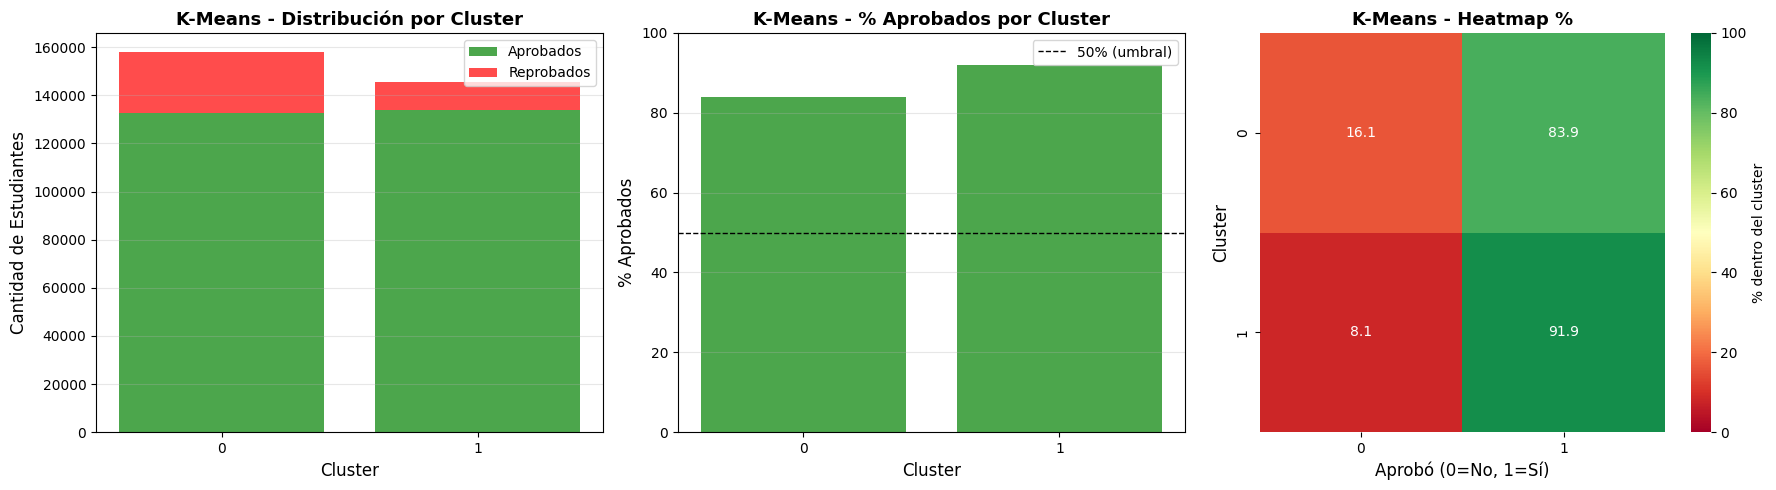


💾 Gráfico guardado en 'models/k-means_vs_objetivo.png'

🏆 MEJOR CLUSTER (mayor % aprobados):
  • Cluster 1: 91.95% aprobados (145619 estudiantes)

⚠️ PEOR CLUSTER (menor % aprobados):
  • Cluster 0: 83.91% aprobados (158090 estudiantes)

📊 EVALUACIÓN: JERÁRQUICO vs VARIABLE OBJETIVO

📈 DISTRIBUCIÓN DE APROBADOS POR CLUSTER:
────────────────────────────────────────────────────────────────────────────────
Cluster    Total      Aprobados    Reprobados   % Aprobados     Riesgo    
────────────────────────────────────────────────────────────────────────────────
0          302410     265393       37017        87.76           🟢 Bajo    
1          1299       1152         147          88.68           🟢 Bajo    
────────────────────────────────────────────────────────────────────────────────

📊 MÉTRICAS DE SEPARACIÓN:
  • Adjusted Rand Index (ARI):        -0.0005 (1=perfecto, 0=aleatorio)
  • Normalized Mutual Info (NMI):     0.0000 (1=perfecto, 0=independiente)
  • Homogeneity:               

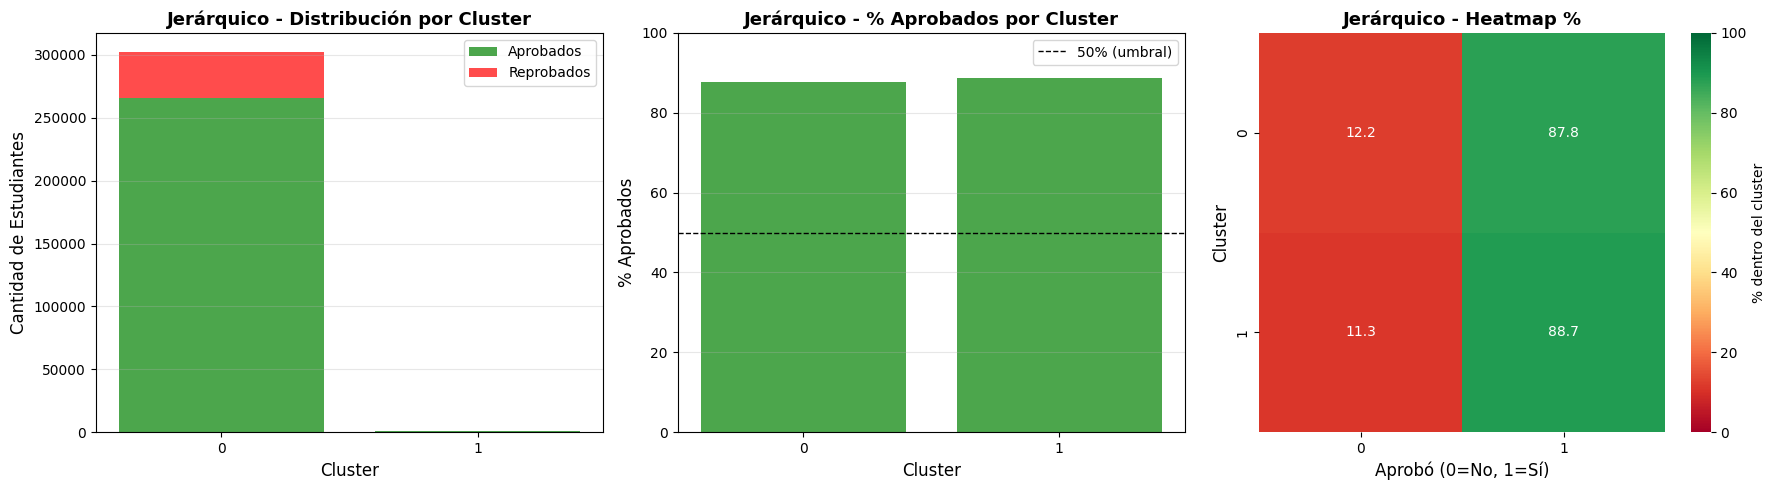


💾 Gráfico guardado en 'models/jerárquico_vs_objetivo.png'

🏆 MEJOR CLUSTER (mayor % aprobados):
  • Cluster 1: 88.68% aprobados (1299 estudiantes)

⚠️ PEOR CLUSTER (menor % aprobados):
  • Cluster 0: 87.76% aprobados (302410 estudiantes)

📊 EVALUACIÓN: DBSCAN vs VARIABLE OBJETIVO

📈 DISTRIBUCIÓN DE APROBADOS POR CLUSTER:
────────────────────────────────────────────────────────────────────────────────
Cluster    Total      Aprobados    Reprobados   % Aprobados     Riesgo    
────────────────────────────────────────────────────────────────────────────────
0          86152      76158        9994         88.40           🟢 Bajo    
1          187620     167456       20164        89.25           🟢 Bajo    
2          29937      22931        7006         76.60           🟡 Medio   
────────────────────────────────────────────────────────────────────────────────

📊 MÉTRICAS DE SEPARACIÓN:
  • Adjusted Rand Index (ARI):        0.0315 (1=perfecto, 0=aleatorio)
  • Normalized Mutual Info (NMI):  

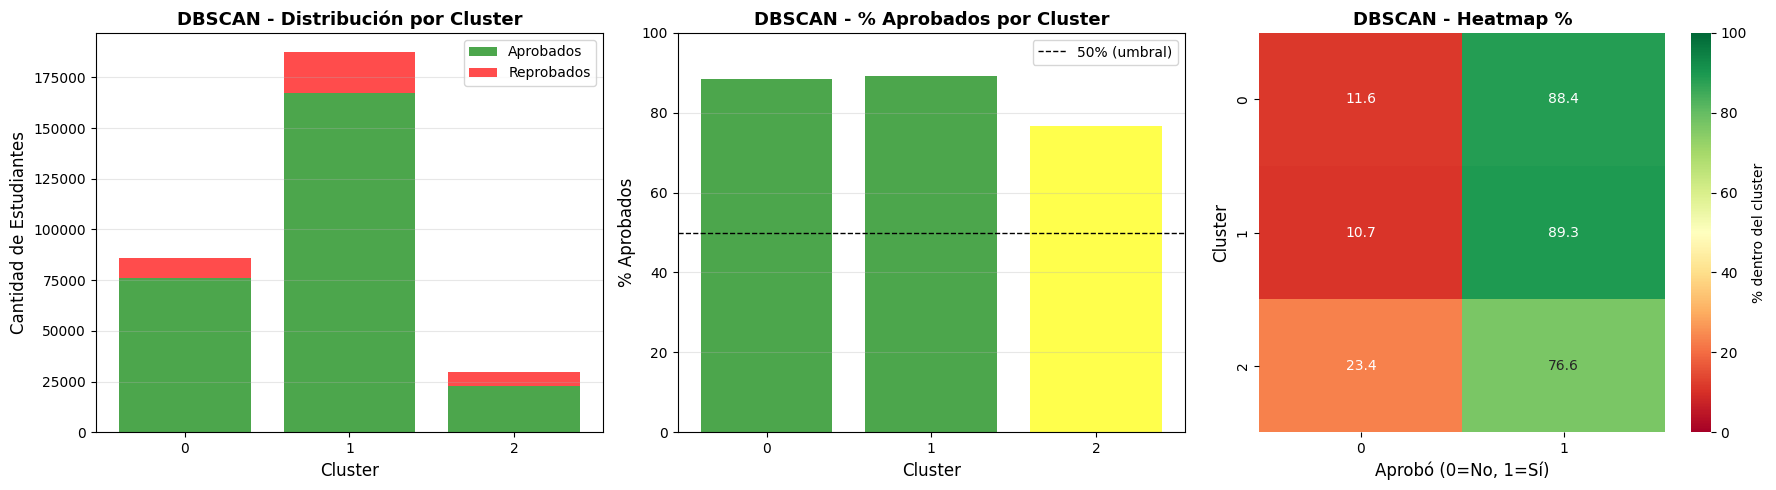


💾 Gráfico guardado en 'models/dbscan_vs_objetivo.png'

🏆 MEJOR CLUSTER (mayor % aprobados):
  • Cluster 1: 89.25% aprobados (187620 estudiantes)

⚠️ PEOR CLUSTER (menor % aprobados):
  • Cluster 2: 76.60% aprobados (29937 estudiantes)

📊 EVALUACIÓN: MEAN SHIFT vs VARIABLE OBJETIVO

📈 DISTRIBUCIÓN DE APROBADOS POR CLUSTER:
────────────────────────────────────────────────────────────────────────────────
Cluster    Total      Aprobados    Reprobados   % Aprobados     Riesgo    
────────────────────────────────────────────────────────────────────────────────
0          295313     260123       35190        88.08           🟢 Bajo    
1          1373       782          591          56.96           🟠 Alto    
2          805        643          162          79.88           🟡 Medio   
3          225        210          15           93.33           🟢 Bajo    
4          347        305          42           87.90           🟢 Bajo    
5          1324       1071         253          80.89          

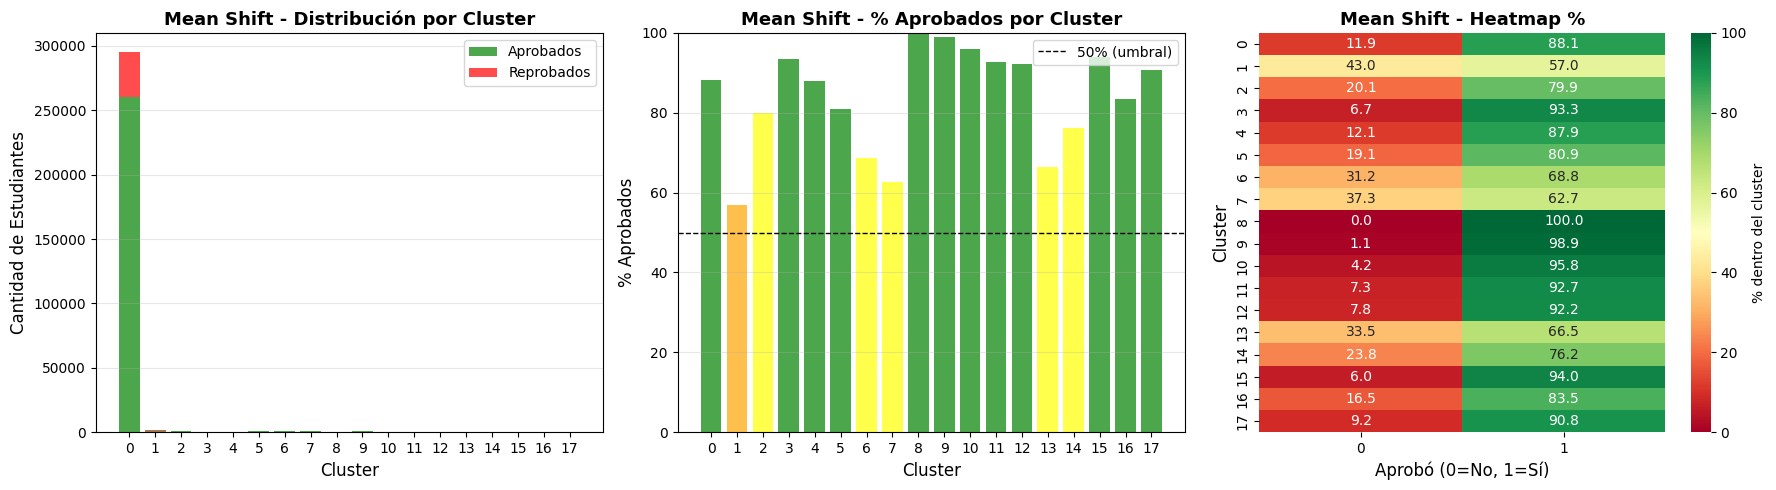


💾 Gráfico guardado en 'models/mean_shift_vs_objetivo.png'

🏆 MEJOR CLUSTER (mayor % aprobados):
  • Cluster 8: 100.00% aprobados (364 estudiantes)

⚠️ PEOR CLUSTER (menor % aprobados):
  • Cluster 1: 56.96% aprobados (1373 estudiantes)


In [78]:
resultados_kmeans = evaluar_clustering_con_objetivo(kmeans_labels, y_unsupervised, 'K-Means')
resultados_hierarchical = evaluar_clustering_con_objetivo(hierarchical_labels, y_unsupervised, 'Jerárquico')
resultados_dbscan = evaluar_clustering_con_objetivo(dbscan_labels, y_unsupervised, 'DBSCAN')
resultados_meanshift = evaluar_clustering_con_objetivo(meanshift_labels, y_unsupervised, 'Mean Shift')

COMPARACIÓN FINAL: CLUSTERING vs VARIABLE OBJETIVO

In [79]:
comparacion_objetivo = pd.DataFrame({
    'Método': ['K-Means', 'Jerárquico', 'DBSCAN', 'Mean Shift'],
    'ARI': [resultados_kmeans['ari'], resultados_hierarchical['ari'],
            resultados_dbscan['ari'] if resultados_dbscan else np.nan,
            resultados_meanshift['ari']],
    'NMI': [resultados_kmeans['nmi'], resultados_hierarchical['nmi'],
            resultados_dbscan['nmi'] if resultados_dbscan else np.nan,
            resultados_meanshift['nmi']],
    'V-Measure': [resultados_kmeans['v_measure'], resultados_hierarchical['v_measure'],
                  resultados_dbscan['v_measure'] if resultados_dbscan else np.nan,
                  resultados_meanshift['v_measure']]
})

In [80]:
print(f"\n{comparacion_objetivo.to_string(index=False)}")

# Mejor método según NMI
mejor_metodo_obj = comparacion_objetivo.loc[comparacion_objetivo['NMI'].idxmax(), 'Método']
print(f"\n🏆 Mejor método según NMI (separación de clases): {mejor_metodo_obj}")

# Guardar
comparacion_objetivo.to_csv('models/clustering_vs_objetivo.csv', index=False)
print(f"\n💾 Comparación guardada en 'models/clustering_vs_objetivo.csv'")


    Método       ARI      NMI  V-Measure
   K-Means  0.001462 0.014466   0.014466
Jerárquico -0.000537 0.000009   0.000009
    DBSCAN  0.031540 0.008605   0.008605
Mean Shift  0.037303 0.011275   0.011275

🏆 Mejor método según NMI (separación de clases): K-Means

💾 Comparación guardada en 'models/clustering_vs_objetivo.csv'


## Final

In [81]:
# Resumen final
print(f"\n{'='*80}")
print(f"✅ ENTRENAMIENTO COMPLETADO")
print(f"{'='*80}")
print(f"\n📁 Archivos guardados en la carpeta 'models/':")
print(f"  ✓ label_encoders.pkl - Encoders para variables categóricas")
print(f"  ✓ feature_info.pkl - Información de features")
print(f"  ✓ random_forest_model.pkl - Modelo Random Forest")
print(f"  ✓ svm_model.pkl - Modelo SVM")
print(f"  ✓ logistic_regression_model.pkl - Modelo Regresión Logística")
print(f"  ✓ xgboost_model.pkl - Modelo XGBoost")
if len(df_inferencia) > 0:
    print(f"  ✓ datos_inferencia_2025_2S.csv - Datos para inferencia futura")

print(f"\n📊 RESUMEN DE DATOS:")
print(f"  • Train: 2020-2024 (80%) - {len(X_train)} registros")
print(f"  • Val: 2020-2024 (20%) - {len(X_val)} registros")
if X_test is not None:
    print(f"  • Test: 2025-1S - {len(X_test)} registros")
if len(df_inferencia) > 0:
    print(f"  • Inferencia: 2025-2S - {len(df_inferencia)} registros (guardados para uso futuro)")

print(f"\n🎯 Variable objetivo: APROBO (1=Reprobado/PF, 0=Aprobado)")
print(f"📊 Total de features: {len(X_columns)}")
print(f"   - Numéricas: {len(features_numericas)}")
print(f"   - Categóricas (encoded): {len(features_encoded)}")


✅ ENTRENAMIENTO COMPLETADO

📁 Archivos guardados en la carpeta 'models/':
  ✓ label_encoders.pkl - Encoders para variables categóricas
  ✓ feature_info.pkl - Información de features
  ✓ random_forest_model.pkl - Modelo Random Forest
  ✓ svm_model.pkl - Modelo SVM
  ✓ logistic_regression_model.pkl - Modelo Regresión Logística
  ✓ xgboost_model.pkl - Modelo XGBoost
  ✓ datos_inferencia_2025_2S.csv - Datos para inferencia futura

📊 RESUMEN DE DATOS:
  • Train: 2020-2024 (80%) - 242967 registros
  • Val: 2020-2024 (20%) - 60742 registros
  • Test: 2025-1S - 28650 registros
  • Inferencia: 2025-2S - 30324 registros (guardados para uso futuro)

🎯 Variable objetivo: APROBO (1=Reprobado/PF, 0=Aprobado)
📊 Total de features: 43
   - Numéricas: 24
   - Categóricas (encoded): 19
